# Imports & Setup

In [2]:
%load_ext autoreload
%autoreload 2

import pathlib
import pyperclip
import matplotlib
import curie as ci
import numpy as np
import pandas as pd
from tendl import Tendl
import periodictable as pt 
from typing import Literal
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from numpy import float64, int64
from matplotlib.figure import Figure
from scipy.optimize import curve_fit 
from scipy.constants import Avogadro 
from dataclasses import dataclass, field 
from uncertainties.umath import exp as uexp # type: ignore
from collections.abc import Iterable, Callable
from uncertainties import ufloat, correlated_values, unumpy, UFloat

%matplotlib inline
matplotlib.rcParams.update({'font.size': 14,
                            'axes.labelsize':   13,
                            'axes.titlesize': 16, 
                            'xtick.labelsize': 12, 
                            'ytick.labelsize': 12, 
                            'legend.fontsize': 10,
                            'figure.titlesize': 16,
                            'figure.figsize': (14, 8)})

     
class Path(pathlib.PosixPath):
    '''Wrapper for pathlib.Path to ensure string representation is used in Spectrum class.'''
    def endswith(self, suffix: str) -> bool:
        return str(self).endswith(suffix)
    
    def split(self, sep: str | None = None) -> list[str]:
        return str(self).split(sep)
    
    def __add__(self, other: str) -> 'Path':
        return Path(str(self) + other)
    
    def __radd__(self, other: str) -> 'Path':
        return Path(other + str(self))
    
root_path = Path.cwd().parent 

spec_filename   = root_path / 'spectra'
spec_calib_path = spec_filename / 'calibration'
spec_exp_path   = spec_filename / 'experiment'
spec_test_path  = spec_filename / 'test'
tendl_data_path = root_path / 'tendl_data'
fig_path        = root_path / 'figs'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Calibration

### Plotting Efficiency Curve

In [15]:
calib_path_Cs = spec_calib_path / 'AA110625_Cs137.Spe'
calib_path_Ba = spec_calib_path / 'AB110625_Ba133.Spe'
calib_path_Eu = spec_calib_path / 'AC110625_Eu152.Spe'

# Extract the spectrums for calibration
cb = ci.Calibration()
sp_Cs137 = ci.Spectrum(calib_path_Cs)
sp_Ba133 = ci.Spectrum(calib_path_Ba)
sp_Eu152 = ci.Spectrum(calib_path_Eu)

# Assign isotopes to the spectrums. Our calibration samples are 100% Cs137, Ba133, and Eu152
# Note: Isotope names must be uppercase
sp_Cs137.isotopes = ['137CS']
sp_Ba133.isotopes = ['133BA']
sp_Eu152.isotopes = ['152EU']


def Ci_to_Bq(Ci: float) -> float:
    """Convert Curie to Becquerel."""
    return Ci * 3.7e10  # 1 Ci = 3.7e10 Bq

# Add information about the sources
# Note: Isotope names must be uppercase
sources = [
    {'isotope': '133BA',
     'A0': Ci_to_Bq(10.78*1e-6),
     'ref_date': '10/01/1988 12:00:00'},
    {'isotope': '137CS', 
     'A0': Ci_to_Bq(11.46*1e-6), 
     'ref_date': '02/01/1979 12:00:00'},
    {'isotope': '152EU',
     'A0': 150*1e3,
     'ref_date': '01/01/2002 12:00:00'}
]

sources = pd.DataFrame(sources)

# IMPORTANT: If calibration is not successful, run cell again with `sp_Eu152.auto_calibrate()` uncommented 
sp_Eu152.auto_calibrate()
cb.calibrate([sp_Ba133, sp_Cs137, sp_Eu152], sources=sources)

# cb.saveas(root_path / 'calibration.json')

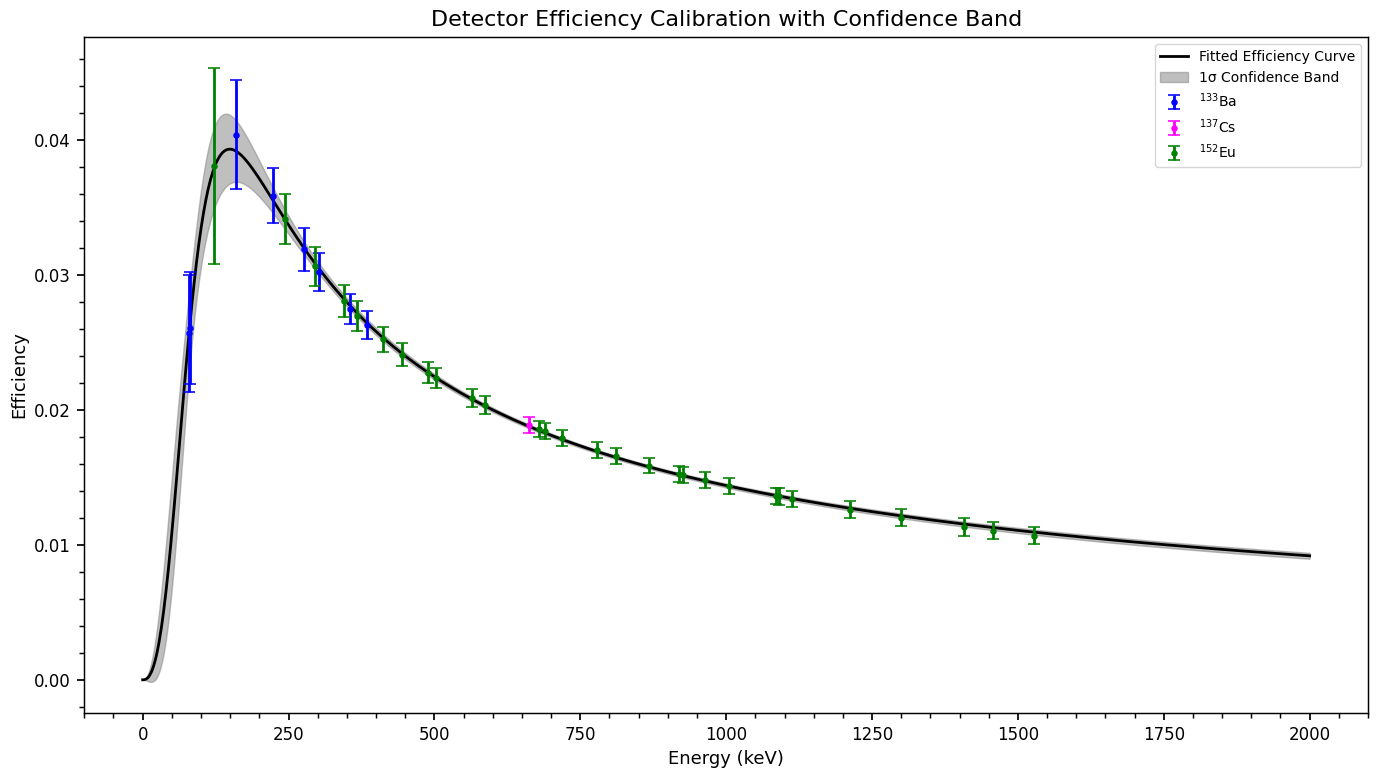

In [16]:
isotope_energy_set = []
efficiencies = []
unc_efficiencies = []
isotopes = []

for sp in [sp_Ba133, sp_Cs137, sp_Eu152]:
    if sp.peaks is None:
        raise ValueError(f"Peaks not found in spectrum {sp.filename}. Ensure the spectrum is calibrated and has peaks detected.")
    
    for energy, ε, unc_ε, iso_name in zip(sp.peaks['energy'], sp.peaks['efficiency'], sp.peaks['unc_efficiency'], sp.peaks['isotope']):
        isotope_energy_set.append(energy)
        efficiencies.append(ε)
        unc_efficiencies.append(unc_ε)
        isotopes.append(iso_name)

isotope_energy_set = np.array(isotope_energy_set)
efficiencies = np.array(efficiencies)
unc_efficiencies = np.array(unc_efficiencies)
        
def efficiency_curve(E, a, b, c, d):
    return a * E**b/(c + E**d)

# Fit the efficiency data to the model
p0 = [20, 1, 5e+4, 2]  # Initial guess for parameters from testing parameters manually
efficiency_curve_params, cov = curve_fit(efficiency_curve, isotope_energy_set, efficiencies, p0=[20, 1, 5e+4, 2], sigma=unc_efficiencies, absolute_sigma=True)

energy_range = np.linspace(0, 2000, 1000)
fitted_efficiency = efficiency_curve(energy_range, *efficiency_curve_params)

# Create correlated ufloat objects for the fitted parameters
u_efficiency_curve_params = correlated_values(efficiency_curve_params, cov)
# Calculate the fitted efficiency with uncertainties
u_fitted_efficiency = efficiency_curve(energy_range, *u_efficiency_curve_params)
# Extract nominal values and standard deviations
fitted_efficiency_nom = unumpy.nominal_values(u_fitted_efficiency)
fitted_efficiency_std = unumpy.std_devs(u_fitted_efficiency)



# Plotting the confidence band
plt.plot(energy_range, fitted_efficiency_nom, color='black', label='Fitted Efficiency Curve')
plt.fill_between(energy_range, 
                 fitted_efficiency_nom - fitted_efficiency_std, 
                 fitted_efficiency_nom + fitted_efficiency_std, 
                 color='gray', alpha=0.5, label='1σ Confidence Band')

plt.errorbar(sp_Ba133.peaks['energy'], sp_Ba133.peaks['efficiency'], yerr=sp_Ba133.peaks['unc_efficiency'], fmt='o', label=r'$^{133}$Ba', color='blue')
plt.errorbar(sp_Cs137.peaks['energy'], sp_Cs137.peaks['efficiency'], yerr=sp_Cs137.peaks['unc_efficiency'], fmt='o', label=r'$^{137}$Cs', color='magenta')
plt.errorbar(sp_Eu152.peaks['energy'], sp_Eu152.peaks['efficiency'], yerr=sp_Eu152.peaks['unc_efficiency'], fmt='o', label=r'$^{152}$Eu', color='green')

plt.xlabel('Energy (keV)')
plt.ylabel('Efficiency')
plt.title('Detector Efficiency Calibration with Confidence Band')
plt.legend()
plt.show()

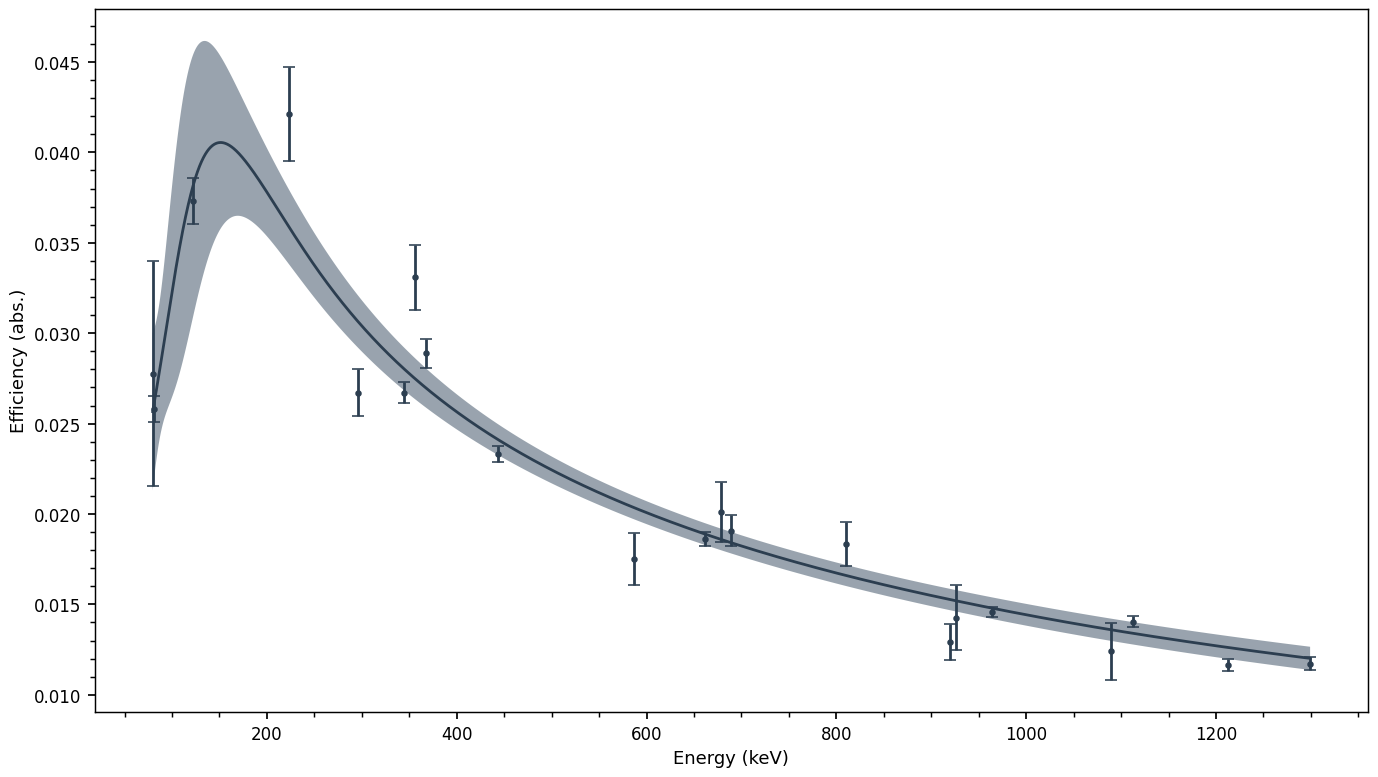

In [17]:
cb.plot_effcal()

# Part 1: Finding Initial Activity

## Analysis

In [18]:
@dataclass
class GammaPeak:
    """
    Data class to hold measurements for a specific gamma-ray energy peak.

    Parameters
    ----------
    energy : float
        The gamma-ray energy in keV.

    Attributes
    ----------
    energy : float
        The gamma-ray energy in keV.
    times : list[float]
        List of measurement times in seconds since the end of irradiation.
    activities : list[float]
        List of measured activities in Bq.
    uncertainties : list[float]
        List of uncertainties in the measured activities.
    n_measurements : int
        The number of measurements for this peak.
        
    Methods
    -------
    add_measurement(time: float, activity: float, uncertainty: float) -> None
        Add a new measurement for this energy peak.
    
    """
    energy: float  # The gamma-ray energy in keV
    # Store measurement data
    times: list[float] = field(default_factory=list)
    activities: list[float] = field(default_factory=list)
    uncertainties: list[float] = field(default_factory=list)
    
    def add_measurement(self, time: float, activity: float, uncertainty: float) -> None:
        """Add a new measurement for this energy peak."""
        self.times.append(time)
        self.activities.append(activity)
        self.uncertainties.append(uncertainty)
   
    @property
    def n_measurements(self) -> int:
        """Return the number of measurements for this peak."""
        return len(self.times)

@dataclass
class IsotopeResults:
    """
    Stores analysis results for a single isotope.

    This data class aggregates all measurements for a specific isotope, organized
    by gamma-ray energy peaks. It also stores the optimal parameters from the
    curve fit.

    Parameters
    ----------
    isotope : str
        The identifier for the isotope (e.g., '108AG').
    peaks : list[GammaPeak], optional
        A list of `GammaPeak` objects for this isotope. Initialized to an empty list.
    A0 : UFloat, optional
        The fitted initial activity (A0) at t=0, as a `UFloat` object from the
        `uncertainties` library. Initialized to 0.
    cov : np.ndarray | None, optional
        The covariance matrix from the activity curve fit. Initialized to `None`.

    Attributes
    ----------
    isotope : str
        The identifier for the isotope.
    peaks : list[GammaPeak]
        List of `GammaPeak` objects, each containing measurements for a specific
        gamma-ray energy.
    A0 : UFloat
        The fitted initial activity (A0) at t=0 with its uncertainty.
    cov : np.ndarray | None
        The covariance matrix from the fit.

    Methods
    -------
    get_peak(energy: float, tolerance: float = 0.5) -> GammaPeak | None
        Finds a `GammaPeak` object for a given energy within a tolerance.
    add_or_update_peak(energy: float, time: float, activity: float, uncertainty: float, tolerance: float = 0.5) -> None
        Adds a measurement to an existing peak or creates a new one.
    """
    isotope: str
    peaks: list[GammaPeak] = field(default_factory=list)
    A0: UFloat = ufloat(0, 1e-16)
    cov: np.ndarray | None = None
    
    def _get_peak(self, energy: float, tolerance: float = 0.5) -> GammaPeak | None:
        """
        Find a peak with the given energy within the specified tolerance.
        Returns None if no matching peak is found.
        """
        for peak in self.peaks:
            if abs(peak.energy - energy) <= tolerance:
                return peak
        return None
    
    def add_or_update_peak(self, energy: float, time: float, activity: float, 
                           uncertainty: float, tolerance: float = 0.5) -> None:
        """
        Adds a measurement to an existing peak or creates a new one.

        This method searches for a `GammaPeak` corresponding to the given `energy`
        within a specified `tolerance`. If a matching peak is found, the new
        measurement (time, activity, uncertainty) is added to it. If no
        matching peak is found, a new `GammaPeak` is created and the
        measurement is added to the new peak.

        Parameters
        ----------
        energy : float
            The gamma-ray energy of the measurement in keV.
        time : float
            The measurement time in seconds since the end of irradiation.
        activity : float
            The measured activity in Bq.
        uncertainty : float
            The uncertainty in the measured activity.
        tolerance : float, optional
            The tolerance in keV for matching an existing energy peak, by default 0.5.
        """
        peak = self._get_peak(energy, tolerance)
        if peak is None:
            # Create a new peak
            peak = GammaPeak(energy=energy)
            self.peaks.append(peak)
        
        # Add the measurement to the peak
        peak.add_measurement(time, activity, uncertainty)
    
class SpectrumAnalysis:
    """
    Analyzes a series of gamma-ray spectrum files to determine the initial
    activity (A0) of specified isotopes.

    This class automates the process of reading multiple spectrum files from a
    time-series measurement, extracting peak information, calculating activities
    for each peak, and performing a combined curve fit to determine the initial
    activity at the end of irradiation.

    Parameters
    ----------
    spec_filename : str | Path
        The base filename for the spectrum files. The class expects a series
        of files named like `spec_filename_000.Spe`, `spec_filename_001.Spe`, etc.
    Δt_d : float
        The delay time in seconds between the end of irradiation and the start
        of the first measurement.
    calibration_source : Path | ci.Calibration, optional
        The path to the calibration file (e.g., 'calibration.json') or a
        pre-loaded `curie.calibration.Calibration` object. Defaults to a file named
        'calibration.json' in the root path.

    Attributes
    ----------
    spec_filename : pathlib.Path
        The path object for the base spectrum filename.
    Δt_d : float
        Delay time in seconds.
    cb : curie.calibration.Calibration
        The calibration object used for analysis.
    job_specs : dict
        A dictionary containing specifications extracted from the filename,
        such as job number, plate number, and irradiation time.
    spectrums : np.ndarray
        An array of `curie.spectrum.Spectrum` objects, one for each measurement loop.
    real_times : np.ndarray
        The real time for each measurement in seconds.
    live_times : np.ndarray
        The live time for each measurement in seconds.
    start_times : list[pd.Timestamp]
        The start time of each measurement.
    time_deltas : np.ndarray
        The time elapsed in seconds from the start of the first measurement
        to the start of each subsequent measurement.
    isotope_energy : set
        A set of tuples, where each tuple contains an isotope identifier and a
        gamma-ray energy (e.g., `('108AG', 632.9)`).
    Ag108 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 108Ag isotope.
    Ag110 : IsotopeResults
        An `IsotopeResults` object containing all measurements and fit results
        for the 110Ag isotope.
    true_times : np.ndarray
        The time for each measurement, corrected for the delay time `Δt_d`,
        in seconds since the end of irradiation.

    Methods
    -------
    plot_activity()
        Generates and displays plots of the activity decay curves for 108Ag and
        110Ag, showing individual peak measurements and the combined fit.

    """
    def __init__(self, spec_filename: str | Path, Δt_d: float, calibration_source: Path | ci.Calibration = root_path / 'calibration.json'):
        # --- Input Validation ---
        if isinstance(spec_filename, str):
            self.spec_filename = Path(spec_filename)
        else:
            self.spec_filename = spec_filename
            
        # Check for valid paths
        spec_path_first_loop = Path(spec_filename + '_000.Spe')
        if not spec_path_first_loop.is_file():
            raise FileNotFoundError(f"First loop of spectrum file not found: {spec_path_first_loop}")
        
        # Check if calibration_file is a Path or a Calibration object
        if isinstance(calibration_source, Path):
            self.calib_path = calibration_source
            if self.calib_path.is_file():
                self.cb = ci.Calibration(self.calib_path)
            else:
                raise FileNotFoundError(f"Calibration file not found: {self.calib_path}")
            
        elif isinstance(calibration_source, ci.Calibration):
            self.calib_path = None
            self.cb = calibration_source
        else:
            raise TypeError("calibration_source must be a Path or a ci.Calibration object")
        
        # --- Initialization ---
        self.Δt_d = Δt_d  # Delay time between irradiation and measurement in seconds
        self.job_specs = self._get_job_specs()
        
        self.isotopes = ['108AG', '110AG']  # Isotopes to analyze
        self.fit_config = {'SNR_min': 3.5, 'dE_511': 9}  # Configuration for fitting
        
        # --- Data Extraction ---
        self.spectrums, self.real_times, self.live_times, self.start_times, self.time_deltas, self.isotope_energy = self._read_spectrums(self.job_specs)

        # --- Activity Calculations ---
        self.Ag108, self.Ag110 = self._calculate_activities(self.spectrums)

        # --- Fitting Activities ---
        self.true_times = self.time_deltas  + self.Δt_d  # Add delay time to real times
        self.Ag108.A0, self.Ag108.cov = self._fit_combined_activity(self.Ag108)
        self.Ag110.A0, self.Ag110.cov = self._fit_combined_activity(self.Ag110)
    

    def _get_job_specs(self):
        """Extract job specifications from the spectrum filename."""
        parts = self.spec_filename.stem.split('_')
        job_specs = {
            'job_number': int(parts[0][3:]),  # Extract job number from 'job1_' -> 1
            'plate_number': int(parts[1][2:]),  # Extract plate number from 'Ag4_' -> 4
            'irradiation_time': int(parts[2][0]), # Extract irradiation time from '1min' -> 1
            'real_time': int(parts[3][4:]),  # Extract real time from 'real10' -> 10
            'num_loops': int(parts[4][4:])  # Extract number of loops from 'loop6' -> 6
            }
        
        return job_specs
    
    def _read_spectrums(self, job_specs: dict[str, int]) -> tuple[np.ndarray, np.ndarray, np.ndarray, list[pd.Timestamp], np.ndarray, set]:
        """Read the spectrum files and return a list of Spectrum objects."""
        # TODO: When done, evalute what list are actually needed
        spectrums      = []
        real_times     = []
        live_times     = [] 
        start_times    = []
        time_deltas    = []
        isotope_energy = set() # ('isotope1', energy1, 'isotope1', energy2, 'isotope2', energy3, ...) 
        
        n_loops = job_specs['num_loops']
        for i in range(n_loops):
            spec_path = self.spec_filename + f'_{i:03d}.Spe'
            spectrum = ci.Spectrum(spec_path)
            spectrum.cb = self.cb
            spectrum.isotopes = self.isotopes
            spectrum.fit_config = self.fit_config
            
            spectrums.append(spectrum)
            real_times.append(spectrum.peaks['real_time'].array[0])  # All peaks have the same real time
            live_times.append(spectrum.peaks['live_time'].array[0])  # All peaks have the same live time
            start_times.append(pd.Timestamp(spectrum.peaks['start_time'].array[0]))  # All peaks have the same start time
            time_deltas.append(pd.Timedelta(start_times[-1] - start_times[0]).total_seconds())
            # Add energies to the set
            isotope_energy.update((zip(spectrum.peaks['isotope'].array, spectrum.peaks['energy'].array)))
            
        real_times  = np.array(real_times)
        live_times  = np.array(live_times)
        spectrums   = np.array(spectrums)
        time_deltas = np.array(time_deltas)
        
        return spectrums, real_times, live_times, start_times, time_deltas, isotope_energy
    
    def _calculate_activities(self, spectrums):
        """Calculate activities for each gamma peak in each spectrum."""
        Ag108 = IsotopeResults('108AG')
        Ag110 = IsotopeResults('110AG')
        self.A0_analytical_108 = []
        self.A0_analytical_110 = []
        # Process each spectrum
        for spec_idx, (spec, time_delta) in enumerate(zip(spectrums, self.time_deltas)):
            # Calculate true time (time since end of irradiation)
            true_time = time_delta + self.Δt_d
            
            # Process each peak in the spectrum
            for E, iso, N_c, unc_N_c, I, unc_I, ε, unc_ε, λ, unc_λ, rt, lt, st in zip(
                    spec.peaks['energy'].array, 
                    spec.peaks['isotope'],
                    spec.peaks['counts'].array, 
                    spec.peaks['unc_counts'].array, 
                    spec.peaks['intensity'].array, 
                    spec.peaks['unc_intensity'].array, 
                    spec.peaks['efficiency'].array, 
                    spec.peaks['unc_efficiency'].array, 
                    spec.peaks['decay_rate'].array, 
                    spec.peaks['unc_decay_rate'].array,
                    spec.peaks['real_time'].array,
                    spec.peaks['live_time'].array,
                    spec.peaks['start_time'].array):
                
                # Get decay constant from isotope library
                λ, unc_λ = ci.Isotope(iso).decay_const(unc=True) # type: ignore
                
                λ_u   = ufloat(λ, unc_λ)
                N_c_u = ufloat(N_c, unc_N_c)
                I_u   = ufloat(I, unc_I)
                ε_u   = ufloat(ε, unc_ε)
                
                # Calculate activity for this peak
                # TODO Is this the correct formula?
                A = (N_c_u * λ_u) / (ε_u * I_u * (1 - uexp(-λ_u * lt))) # type: ignore
                A0_approx = self.A0_func(N_c_u, λ_u, ε_u, I_u, lt, true_time)
                
                # Add the measurement to the appropriate isotope result
                if iso == '108AG':
                    Ag108.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_108.append(A0_approx.nominal_value)
                elif iso == '110AG':
                    Ag110.add_or_update_peak(
                        energy=E, 
                        time=true_time,
                        activity=A.nominal_value,
                        uncertainty=A.std_dev
                    )
                    self.A0_analytical_110.append(A0_approx.nominal_value)
                else:
                    print(f"Warning: Unrecognized isotope {iso} in spectrum {spec_idx}. Skipping.")
        
        return Ag108, Ag110
                    
    def _fit_combined_activity(self, iso_results: IsotopeResults):
        """Fit activity curve using all peaks for an isotope."""
        # Collect all times, activities, and uncertainties across all peaks
        all_times = []
        all_activities = []
        all_uncertainties = []

        for peak in iso_results.peaks:
            all_times.extend(peak.times)
            all_activities.extend(peak.activities)
            all_uncertainties.extend(peak.uncertainties)
            
        if len(all_times) == 0:
            raise ValueError(f"No measurements found for isotope {iso_results.isotope}. Cannot fit activity curve.")

        # Sorts all data by time
        sorted_data = sorted(zip(all_times, all_activities, all_uncertainties), key=lambda x: x[0])
        all_times, all_activities, all_uncertainties = zip(*sorted_data)
        
        # Fitting the data
        λ = ci.Isotope(iso_results.isotope).decay_const()
        try:
            params, cov = curve_fit(
                lambda t, A0: self._activity_model(t, λ, A0),
                all_times, 
                all_activities, 
                p0=[max(all_activities)], 
                sigma=all_uncertainties, 
                absolute_sigma=True
            )
            A0 = ufloat(params[0], np.sqrt(cov[0, 0]))
            return A0, cov
        
        except ValueError:
            raise ValueError(f'Error fitting activity as measurement data contains NaN, inf.\nTimes: {all_times}\nActicvities: {all_activities}')

        except RuntimeError:
            raise RuntimeError(f'Failed least squares fit for isotope {iso_results.isotope}. Check data quality or fitting parameters.')
            
    def _plot_isotope_data(self, ax, iso_results):
        """Plot data for a specific isotope."""
        # Check iso_results for possible issues
        
        
        # TODO Evalute using differnt colors
        # Use a different color for each energy peak
        # colors = plt.cm.tab10(np.linspace(0, 1, len(iso_results.peaks)))
        # colors = plt.cm.brg(np.linspace(0, 1, len(iso_results.peaks)))
        # colors = plt.cm.Set1(np.linspace(0, 1, len(iso_results.peaks)))
        
        # Plot each energy peak with its own color
        for i, peak in enumerate(iso_results.peaks):
            # if peak.n_measurements > 0:
            label = f"{peak.energy:.1f} keV"
            ax.errorbar(
                peak.times, 
                peak.activities, 
                yerr=peak.uncertainties, 
                fmt='o:', 
                capsize=5,
                # color=colors[i],
                label=label,
                alpha=1-.2*i,  # Decrease alpha for each peak
            )
        
        # Get time range for plotting
        all_times = []
        for peak in iso_results.peaks:
            all_times.extend(peak.times)
        
        # if all_times:
        t_min = min(all_times)
        t_max = max(all_times)
        plot_times = np.linspace(0, t_max * 1.1, 100)
        
        # Get decay constant
        λ = ci.Isotope(iso_results.isotope).decay_const()
        
        # Plot fit line
        fit_line = self._activity_model(plot_times, λ, iso_results.A0.nominal_value)
        ax.plot(plot_times, fit_line, 'k-', 
                label=f'Combined Fit')
        
        # Plot confidence band
        # if iso_results.cov is not None:
        # Calculate uncertainty in fit
        fit_unc = np.abs(fit_line * (iso_results.A0.std_dev / iso_results.A0.nominal_value))
        ax.fill_between(plot_times, 
                    fit_line - fit_unc, 
                    fit_line + fit_unc, 
                    color='gray', alpha=0.3, label='1σ Confidence Band')

    
        # formatted_iso_name = rf'$^{iso_results.isotope[:3]}$Ag'
        formatted_iso_name = rf'$^{{{iso_results.isotope[:3]}}}$Ag'
        ax.set_title(formatted_iso_name + f'\nA₀={iso_results.A0:.2uP} Bq')
        ax.set_xlabel('Time since irradiation end [s]')
        ax.set_ylabel('Activity [Bq]')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    def plot_activity(self, save_fig: bool = True):
        """Plot activities for each isotope, with different colors for different energy peaks."""
        plt.figure()
        # Plot 108Ag data
        ax1 = plt.subplot(1, 2, 1)
        self._plot_isotope_data(ax1, self.Ag108)
        
        # Plot 110Ag data
        ax2 = plt.subplot(1, 2, 2)
        self._plot_isotope_data(ax2, self.Ag110)
        
        plt.suptitle(f'Activity Analysis for {self.spec_filename.stem}')
        plt.tight_layout()
        
        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_activity_analysis'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
    
    def plot_A0_analytical(self, save_fig: bool = True):
        """Plot the analytical A0 values for each isotope and peak."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

        # --- Plot for 108Ag ---
        for peak in self.Ag108.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_108, self.A0_analytical_108) if abs(e - peak.energy) < 0.5]
            ax1.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')
        
        formatted_iso_name_108 = rf'$^{{{self.Ag108.isotope[:3]}}}$Ag'
        ax1.set_title(f'Analytical A₀ for {formatted_iso_name_108}')
        ax1.set_xlabel('Measurement Index')
        ax1.set_ylabel('Analytical A₀ [Bq]')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # --- Plot for 110Ag ---
        for peak in self.Ag110.peaks:
            # Filter the A0 values for the current peak energy
            a0_values = [a0 for e, a0 in zip(self.A0_analytical_110, self.A0_analytical_110) if abs(e - peak.energy) < 0.5]
            ax2.plot(range(len(a0_values)), a0_values, 'o--', label=f'{peak.energy:.1f} keV')

        formatted_iso_name_110 = rf'$^{{{self.Ag110.isotope[:3]}}}$Ag'
        ax2.set_title(f'Analytical A₀ for {formatted_iso_name_110}')
        ax2.set_xlabel('Measurement Index')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.suptitle(f'Analytical A₀ Calculation for {self.spec_filename.stem}')
        plt.tight_layout(rect=(0., 0.03, 1., 0.95))

        if save_fig:
            path = fig_path / f'{self.spec_filename.stem}_A0_analytical'
            plt.savefig(path.with_suffix('.pdf'))
            plt.savefig(path.with_suffix('.png'))
        plt.show()
        
        
    def _activity_model(self, t, λ, A0):
        """Model for activity decay."""
        return A0*np.exp(-λ*t)
    
    # TODO: Contemplate discarding analytical A0 calculation
    def A0_func(self, N_c, λ, ε, I_γ, Δt_c, Δt_d):
        return (N_c * λ) / (ε * I_γ * (1 - uexp(-λ * Δt_c))) * uexp(λ * Δt_d)

### Job 1:
- Plate id: 4
- Irradiation time: 1 min
- Real time: 10s 
- Num loops: 6

In [19]:
analysis_1 = SpectrumAnalysis(spec_exp_path / 'job1_Ag4_1min_real10_loop6', Δt_d=15)

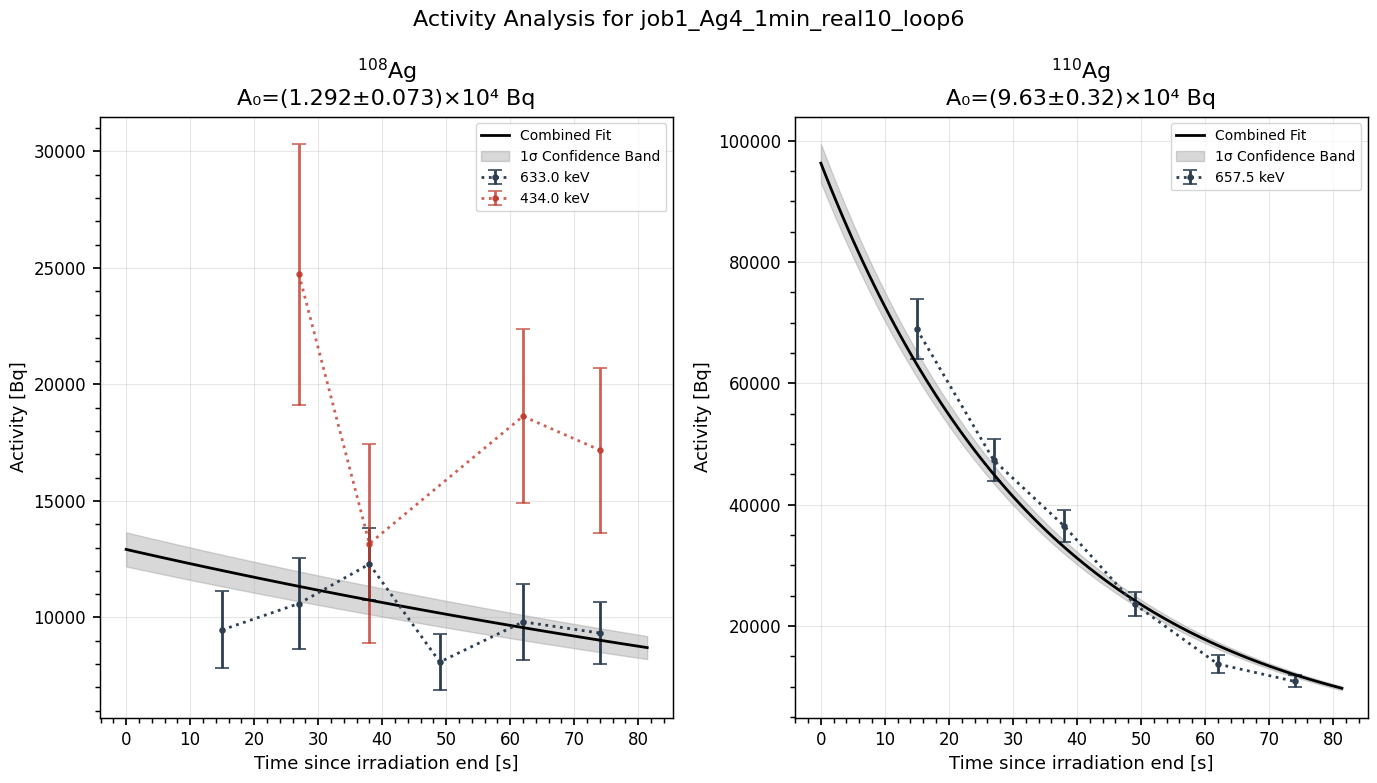

In [20]:
analysis_1.plot_activity()

### Job 2:
- Plate id: 10
- Irradiation time: 2 min
- Real time: 30s
- Num loops: 6

In [21]:
analysis_2 = SpectrumAnalysis(spec_exp_path / 'job2_Ag10_2min_real30_loop6', Δt_d=11)

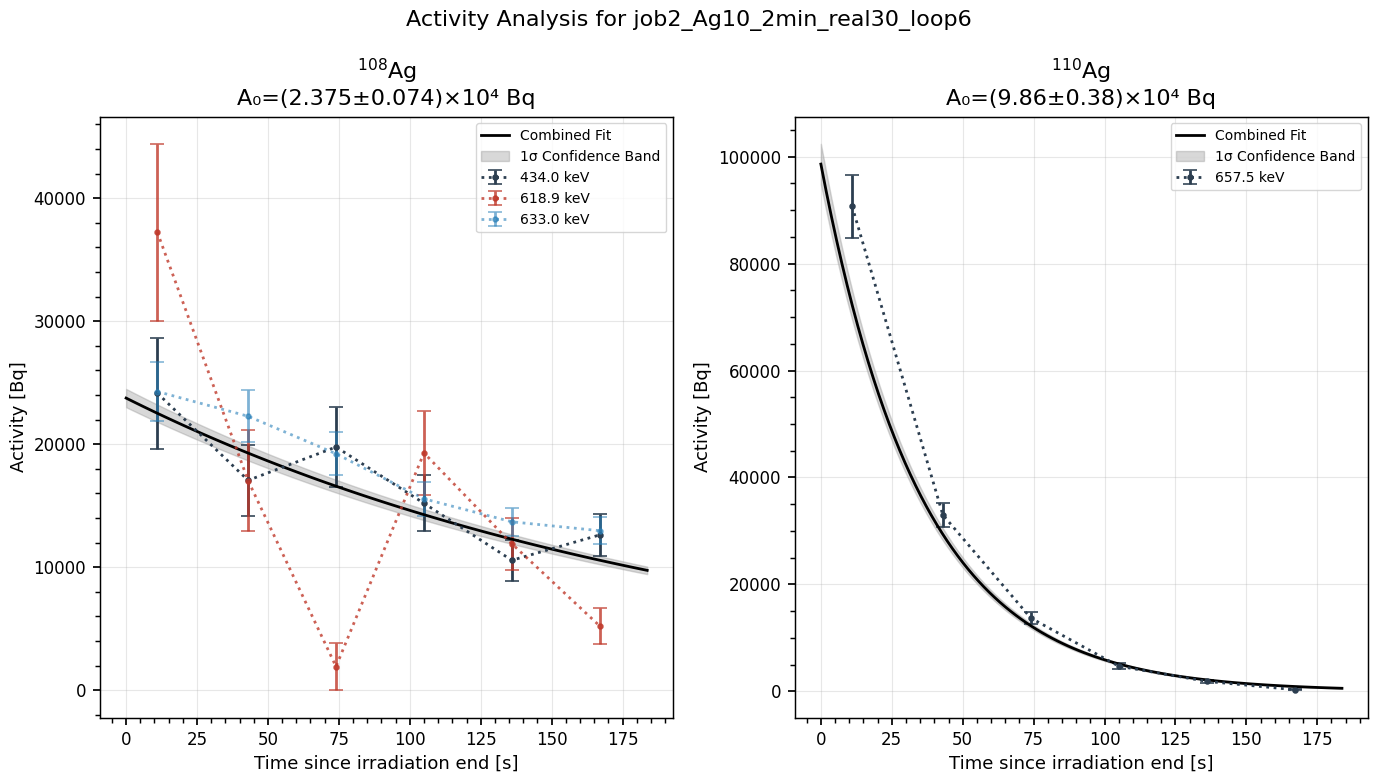

In [22]:
analysis_2.plot_activity()

### Job 3:
- Plate id: 73
- Irradiation time: 3 min
- Real time: 40s
- Num loops: 3

In [23]:
analysis_3 = SpectrumAnalysis(spec_exp_path / 'job3_Ag73_3min_real40_loop3', Δt_d=11)

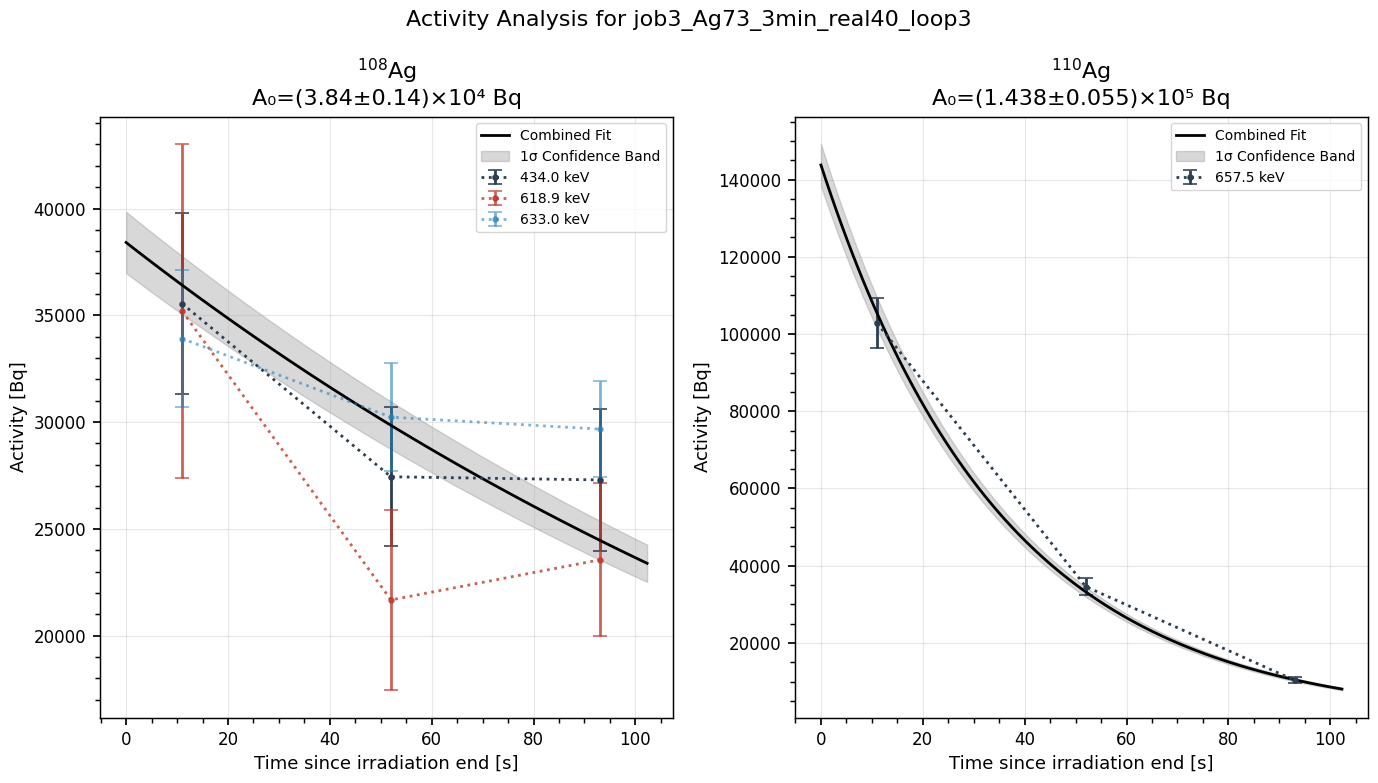

In [24]:
analysis_3.plot_activity()

### Job 4:
- Plate id: 2
- Irradiation time: 3 min
- Real time: 120s
- Num loops: 1

In [25]:
analysis_4 = SpectrumAnalysis(spec_exp_path / 'job4_Ag2_3min_real120_loop1', Δt_d=14)

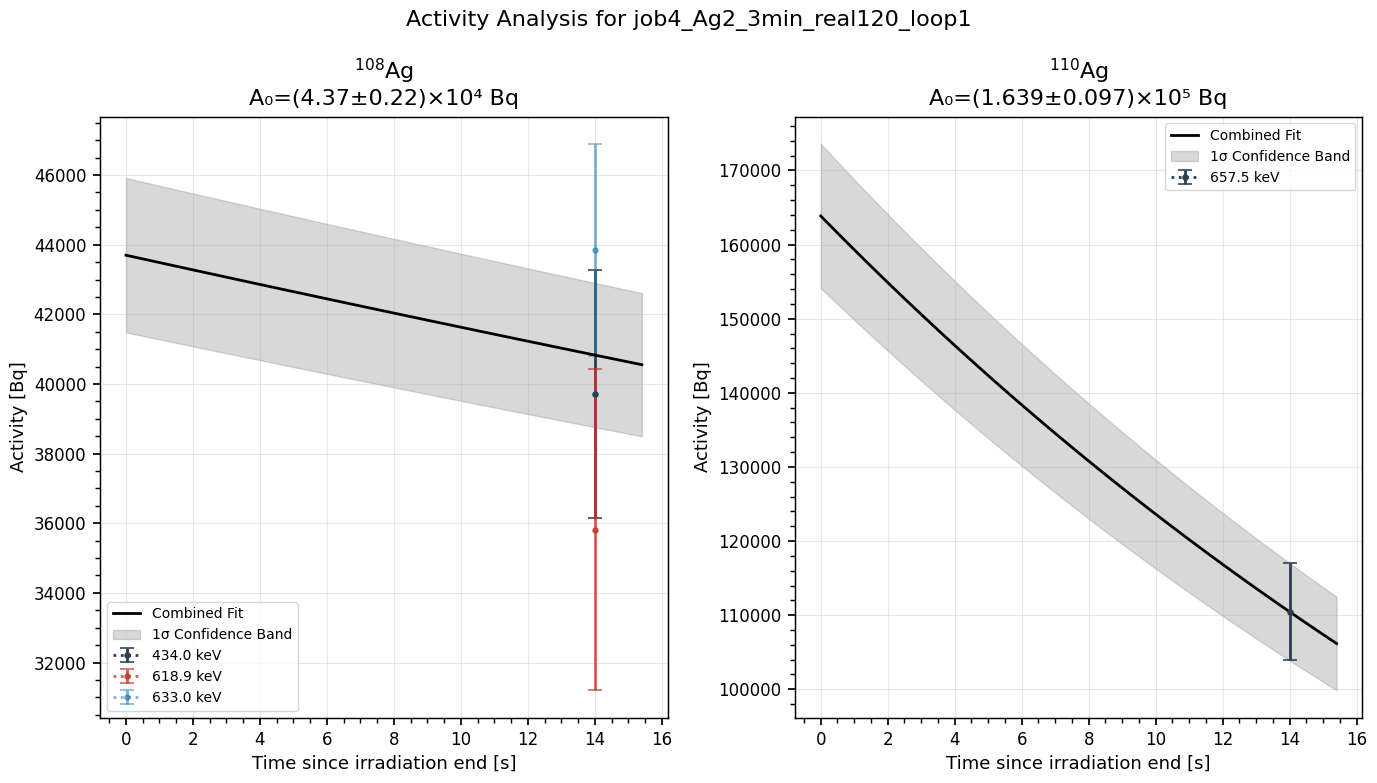

In [26]:
analysis_4.plot_activity()

### Job 5:
- Plate id: 4
- Irradiation time: 3 min
- Real time: 5s
- Num loops: 6

In [27]:
analysis_5 = SpectrumAnalysis(spec_exp_path / 'job5_Ag5_3min_real5_loop6', Δt_d=7)

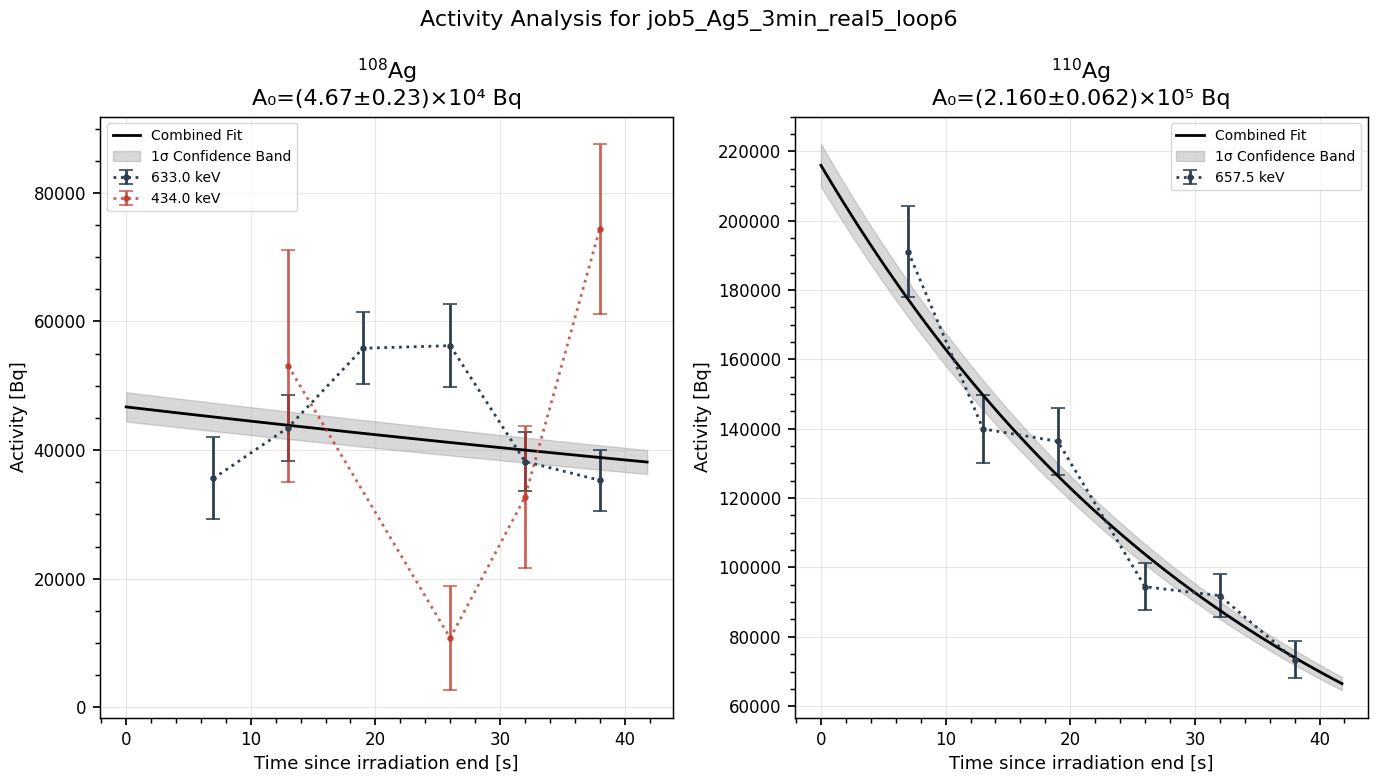

In [28]:
analysis_5.plot_activity()

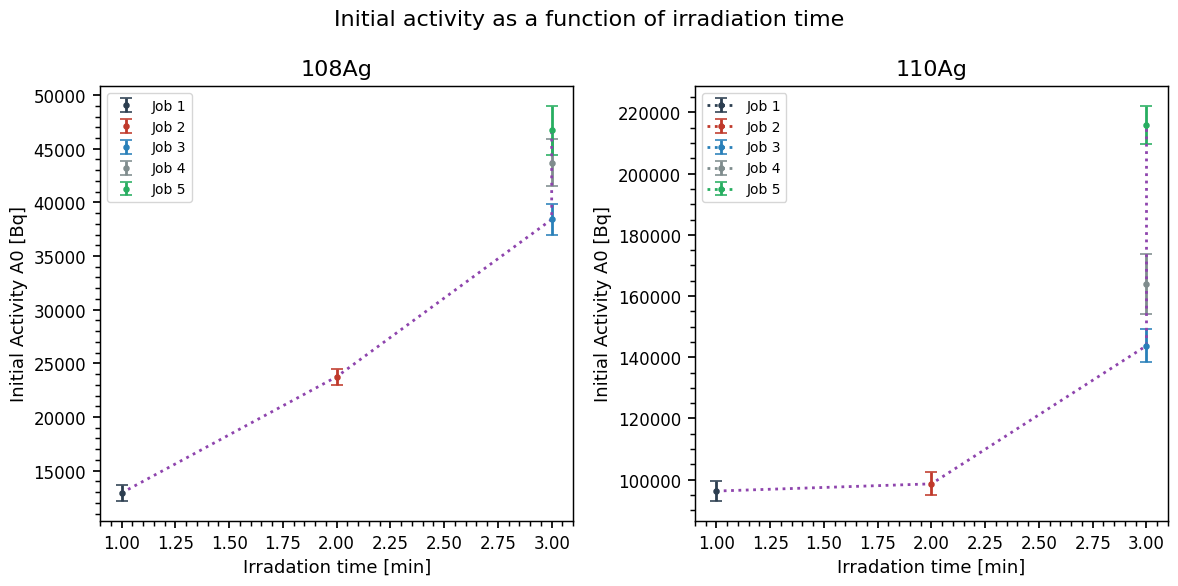

In [29]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    plt.errorbar(irr, _A0, yerr=A0_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, A0_values_108, linestyle=':')

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    plt.errorbar(irr, _A0, yerr=A0_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, A0_values_110, linestyle=':')
    
plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Initial activity as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'initial_activity_vs_irradiation_time.png')
plt.show()

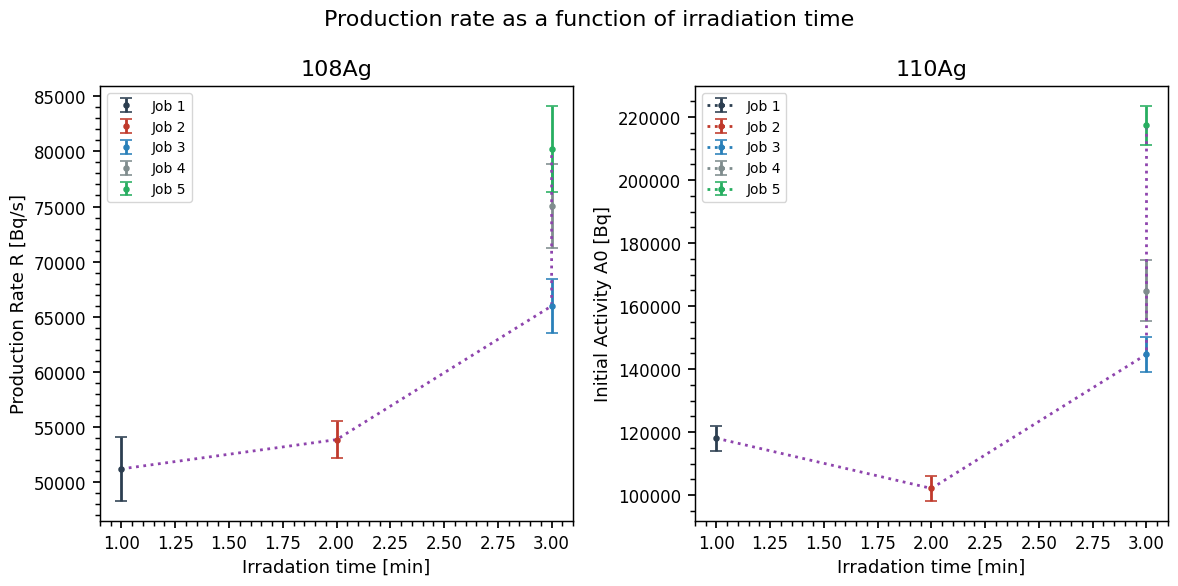

In [30]:
all_analyses = [analysis_1, analysis_2, analysis_3, analysis_4, analysis_5]
analysis_names = ['Job 1', 'Job 2', 'Job 3', 'Job 4', 'Job 5']
irradiation_times = [analysis.job_specs['irradiation_time'] for analysis in all_analyses]
A0_values_108 = [analysis.Ag108.A0.nominal_value for analysis in all_analyses]
A0_values_110 = [analysis.Ag110.A0.nominal_value for analysis in all_analyses]
A0_uncertainties_108 = [analysis.Ag108.A0.std_dev for analysis in all_analyses]
A0_uncertainties_110 = [analysis.Ag110.A0.std_dev for analysis in all_analyses] 

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_108, A0_uncertainties_108, analysis_names):
    λ = ci.Isotope('108AG').decay_const()
    R = _A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds # type: ignore
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate # type: ignore
    plt.errorbar(irr, R, yerr=R_unc, fmt='o', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_108, irradiation_times)], linestyle=':') # type: ignore

plt.xlabel('Irradation time [min]')
plt.ylabel('Production Rate R [Bq/s]')
plt.title('108Ag')
plt.legend()

plt.subplot(1, 2, 2)
for irr, _A0, A0_unc, job_number in zip(irradiation_times, A0_values_110, A0_uncertainties_110, analysis_names):
    λ = ci.Isotope('110AG').decay_const()
    R = _A0 / (1 - np.exp(-λ * irr * 60))  # Convert minutes to seconds # type: ignore
    R_unc = A0_unc / (1 - np.exp(-λ * irr * 60))  # Uncertainty in production rate # type: ignore
    plt.errorbar(irr, R, yerr=R_unc, marker='o', linestyle=':', label=job_number)
plt.plot(irradiation_times, [A0 / (1 - np.exp(-λ * irr * 60)) for A0, irr in zip(A0_values_110, irradiation_times)], linestyle=':') # type: ignore

plt.xlabel('Irradation time [min]')
plt.ylabel('Initial Activity A0 [Bq]')
plt.title('110Ag')
plt.legend()

plt.suptitle('Production rate as a function of irradiation time')
plt.tight_layout()
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.pdf')
plt.savefig(fig_path / 'production_rate_vs_irradiation_time.png')
plt.show()

# Part 2: Cross Sections

In [31]:
class CrossSectionAnalysis:
    """
    Class to analyze cross-section data for isotopes.
    """ 
    def __init__(self, 
                 target: str|list[str], 
                 particle_beam: Literal['proton', 'neutron', 'deuteron'] = 'proton', 
                 n_alpha: int = 3, 
                 max_half_life: float = 100, 
                 min_half_life: float = 60, 
                 grayzone_half_life: float = 10
                 ) -> None:
        """
        Initializes the CrossSectionAnalysis class.

        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. All naturally occurring isotopes will be used. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
        particle_beam : Literal['proton', 'neutron', 'deuteron'], optional
            The type of particle beam used, e.g., 'proton', 'neutron' or 'deuteron'. Defaults to 'proton'.
        n_alpha : int, optional
            The span of decays to consider. Defaults to 3.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to 100.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to 60.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to 10.
        """
        
        self.target = target
        self.particle_beam = particle_beam
        self.n_alpha = n_alpha
        
        self.max_half_life = max_half_life
        self.min_half_life = min_half_life
        self.grayzone_half_life = grayzone_half_life
        
        # Get all products from the target material and particle beam
        self.products = self._get_products(target, particle_beam, n_alpha)
        
        # Filter products based on half-life criteria
        self.observed_isotopes, self.grayzone_isotopes = self._filter_products_halflife(self.products, max_half_life=max_half_life, min_half_life=min_half_life, grayzone_half_life=grayzone_half_life
        )
        
        # Create Tendl objects for cross-section data
        self.tendl = Tendl(self._target_abundance(), self.particle_beam)
        
        
    # TODO: Maybe make a single row for "observed", then add "✔", "✘" or "~" for each possible state
    def isotope_overview(self, isotopes: Iterable[str] | None = None, max_half_life: float | None = None, min_half_life: float | None = None, grayzone_half_life: float | None = None, copy_to_clipboard: bool = False, print_markdown: bool = False) -> pd.DataFrame:
        """
        Creates an overview of isotopes with their half-lives and observation status.

        Parameters
        ----------
        isotopes : list[str], optional
            A list of isotope names to include in the overview. If `None`, uses all products found from the target and particle beam upon initialization.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to the class attribute `max_half_life`.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to the class attribute `min_half_life`.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to the class attribute `grayzone_half_life`.
        copy_to_clipboard : bool, optional
            If `True`, copies a markdown table created from the dataframe to the clipboard. Defaults to `False`.  
        print_markdown : bool, optional
            If `True`, prints the markdown table to the console. Defaults to `False`.
        
        Returns
        -------
        pd.DataFrame
            A DataFrame containing isotope information with columns for half-life and observation status.
        """
        if isotopes is None:
            isotopes = self.products
        else:
            isotopes = [iso.upper() for iso in isotopes]  # Ensure isotopes are in uppercase
            
        if max_half_life is None:
            max_half_life = self.max_half_life
            
        if min_half_life is None:
            min_half_life = self.min_half_life
            
        if grayzone_half_life is None:
            grayzone_half_life = self.grayzone_half_life
        
        # Temporarily convert names to Isotope objects for filtering
        isotopes = [ci.Isotope(name.upper()) for name in isotopes]
        isotopes = sorted(isotopes, key=lambda iso: (iso.Z, iso.N), reverse=True) # Sort by Z and N in descending order
        isotopes = [iso._short_name for iso in isotopes] 
        
        # If no new filters are applied, use the already filtered lists to avoid unnecessary printing and processing
        if max_half_life == self.max_half_life and min_half_life == self.min_half_life and grayzone_half_life == self.grayzone_half_life:
            observed_isotopes, grayzone_isotopes = self.observed_isotopes, self.grayzone_isotopes
        else:
            observed_isotopes, grayzone_isotopes = self._filter_products_halflife(isotopes, max_half_life=max_half_life, min_half_life=min_half_life, grayzone_half_life=grayzone_half_life)
        
        data = []
        for iso_name in isotopes:
            if iso_name in observed_isotopes:
                observed = True
                not_observed = False
                maybe_observed = False
            elif iso_name in grayzone_isotopes:
                observed = False
                not_observed = False
                maybe_observed = True
            else:
                observed = False
                not_observed = True
                maybe_observed = False
            
            iso = ci.Isotope(iso_name.upper())
            unit = iso.optimum_units()
            hf = iso.half_life(units=unit)
            hf_formatted = f'{hf:.2g} {unit}' if hf != np.inf else 'Stable'
            
            data.append({
                "Isotope": iso_name.title(),
                "Half-life": hf_formatted,
                "Observed": observed,
                "Not Observed": not_observed,
                "Maybe Observed": maybe_observed
            })
        
        df = pd.DataFrame(data)
        formatted_df = self._format_dataframe_with_checkboxes(df)
        
        if copy_to_clipboard:
            markdown_table = formatted_df.to_markdown(index=False)
            pyperclip.copy(markdown_table)
            print("\nMarkdown table copied to clipboard.")
        if print_markdown:
            markdown_table = formatted_df.to_markdown(index=False)
            print(markdown_table)
        
        return df
    
    def save_tendl_data(self, path: Path, isotopes: Iterable[str] | None = None, Elimit: float = 60, silent: bool = False) -> None:
        """
        Saves Tendl cross-section data for specified isotopes to a .npy file.
        
        Parameters
        ----------
        path : Path
            The path where the data will be saved.
        isotopes : list[str] | None, optional
            A list of isotope names to save. e.g., ['Ag108', 'Ag110']. If `None`, saves all products found from the target and particle beam upon initialization.
        Elimit : float, optional
            The energy limit for the cross-section data. Defaults to 60 MeV.
        silent : bool, optional
            If `True`, suppresses print statements. Defaults to `False`.
        """
        if isotopes is None:
            isotopes = self.products
        
        if not path.exists():
            path.mkdir(parents=True, exist_ok=True)
        
        for iso_name in isotopes:
            iso = ci.Isotope(iso_name.upper())
            Z, A = str(iso.Z), str(iso.A)
            E, Cs = self.tendl.tendlData(Z, A, Elimit=Elimit)
            if E is None or Cs is None:
                if not silent:
                    print(f"No cross-section data found for {iso_name}. Skipping.")
                continue
            else:
                np.save(path / f'{iso_name.title()}.npy', np.array([E, Cs]))
    
    def load_tendl_data(self, path: Path, isotopes: Iterable[str] | None = None, store: bool = True) -> pd.DataFrame:
        """
        Loads Tendl cross-section data from .npy files in the specified directory for given isotopes.
        
        Parameters
        ----------
        path : Path
            The path where the data is stored.
        isotopes : list[str], optional
            A list of isotope names to load. e.g., ['Ag108', 'Ag110']. If `None`, loads all products found from the target and particle beam upon initialization.
        store : bool, optional
            If `True`, stores the loaded data in the `loaded_data` attribute of the class. Defaults to `True`.
            
        Returns
        -------
        pd.DataFrame
            A DataFrame containing isotope 'Name', 'E' (energies), and 'Cs' (cross-sections).
        """
        if isotopes is None:
            isotopes = self.products
        
        if not path.exists():
            raise FileNotFoundError(f"The directory {path} does not exist.")
        
        data = {iso.upper(): self._load_npy(path / f'{iso.title()}.npy') for iso in isotopes}
        
        data = pd.DataFrame({
            'Name': [iso.title() for iso in data.keys()],
            'E': [data[iso][0] for iso in data.keys()],
            'Cs': [data[iso][1] for iso in data.keys()]
        })
        
        if store:
            self.loaded_data = data
        return data
    
    def plot_Cs(self, title: str, isotopes: pd.DataFrame, low_Cs_threshold: float = 10) -> Figure:
        """
        Plots cross-section data for isotopes with cross-sections above a specified threshold.
        
        Parameters
        ----------
        title : str
            The title of the plot.
        isotopes : pd.DataFrame
            A DataFrame containing isotope names, energies, and cross-sections. It should have columns 'Name', 'E', and 'Cs'.
        low_Cs_threshold : float, optional
            The threshold for a cross-section to be considered low. Defaults to 10.
        """
        
        
        # Plot the filtered isotopes
        colors = plt.cm.tab20(np.linspace(0, 1, len(isotopes)))
        linestyles = ['-', '--', '-.']
        for i, iso in enumerate(isotopes.itertuples()):
            iso_name = iso.Name
            E = iso.E
            Cs = iso.Cs
            
            max_Cs = np.max(Cs)
            if max_Cs > low_Cs_threshold:
                label = f"{ci.Isotope(iso_name.upper()).TeX}"
                linestyle = linestyles[i % len(linestyles)]
            else:
                label = fr"{ci.Isotope(iso_name.upper()).TeX}$^{'*'}$"
                linestyle = ':'
            
            plt.plot(E, Cs, label=label, color=colors[i % len(colors)], linestyle=linestyle)
            
        
        plt.xlabel('Energy (MeV)')
        plt.ylabel('Cross-section (mb)')
        plt.suptitle(title, y=0.95)
        plt.title(f'Isotopes marked with * have a maximum cross-section below {low_Cs_threshold} mb.', fontsize=10)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        
        
        return plt.gcf()  # Return the current figure for further manipulation or saving
    
    def filter_products_Cs(self, isotopes: Iterable[str] | None = None, Cs_threshold: float = 1e-2, E_limit: float | None = 60, E_beam: float | None = None) -> pd.DataFrame:
        """
        Filters isotopes based on cross-section data above a specified threshold.
        
        Parameters
        ----------
        isotopes : Iterable[str] | None, optional
            An Iterable of isotope names to filter. If `None`, uses the observed isotopes from the loaded data from `load_tendl_data`. Defaults to `None`.
        Cs_threshold : float, optional
            The threshold for cross-sections to be considered. Defaults to 1e-2 mb.
        E_limit : float | None, optional
            The upper energy limit for the cross-section data. If `None`, uses the entire range from tendl. Defaults to 60 MeV.
        E_beam : float | None, optional
            The energy of the particle beam. If provided, will be the energy which is used to filter the cross-section data. If `None`, searches the entire energy range specified by `E_limit` for a cross-section above `Cs_threshold`. Defaults to `None`.
        """
        
        data = {}
        if isotopes is None:
            if not hasattr(self, 'loaded_data'):
                raise ValueError("No loaded data found. Please load data using `load_tendl_data()` method before plotting or provide isotopes.")   
            
            for iso in self.loaded_data.itertuples():
                E = iso.E
                Cs = iso.Cs
                iso_name = iso.Name.upper() # type: ignore
                if iso_name in self.observed_isotopes:
                    data[iso_name] = (E, Cs)
                    
        
        # If isotopes is a list of strings
        elif all(isinstance(iso, str) for iso in isotopes):
            # Use loaded data if available
            if hasattr(self, 'loaded_data'):
                for iso_name in isotopes:
                    iso_name = iso_name.title()
                    if iso_name in self.loaded_data:
                        E, Cs = self.loaded_data[iso_name]
                        data[iso_name] = (E, Cs)
                    else:
                        iso = ci.Isotope(iso_name.upper())
                        Z, A = str(iso.Z), str(iso.A)
                        E, Cs = self.tendl.tendlData(Z, A, Elimit=E_limit)
                        if E is not None and Cs is not None:
                            data[iso._short_name] = (E, Cs)
            
            # If no loaded data, fetch from Tendl
            else:            
                for iso in isotopes:
                    iso = ci.Isotope(iso.upper())
                    Z, A = str(iso.Z), str(iso.A)
                    E, Cs = self.tendl.tendlData(Z, A, Elimit=E_limit)
                    if E is not None and Cs is not None:
                        data[iso._short_name] = (E, Cs)
        

        else:
            raise TypeError(f"Invalid type for isotopes: {type(isotopes)}. Expected list of strings, or None to use loaded data for all products.")
        
        if E_beam is None:
            conditon = lambda E, Cs: np.max(Cs) > Cs_threshold
        else:
            conditon = lambda E, Cs: Cs[np.abs(E - E_beam).argmin()] > Cs_threshold
        
        # Filter isotopes based on cross-section threshold
        filtered_isotopes = {'Name': [], 'E': [], 'Cs': []}
        for i, (iso_name, (E, Cs)) in enumerate(data.items()):
            if conditon(E, Cs):
                filtered_isotopes['Name'].append(iso_name.title())
                filtered_isotopes['E'].append(E)
                filtered_isotopes['Cs'].append(Cs)
        
        
        # Sort isotopes by maximum cross-section value in descending order
        sorted_filtered_isotopes = pd.DataFrame(filtered_isotopes).sort_values(by='Cs', key=lambda x: x.apply(np.max), ascending=False, ignore_index=True)
        
        print(f'Found {len(sorted_filtered_isotopes)}/{len(data)} isotopes with cross-sections above {Cs_threshold} mb' + f'{" at E = " + str(E_beam) + " MeV:" if E_beam is not None else "" + ":"}')
        print(' '.join(sorted_filtered_isotopes['Name'].tolist()))
        
        return sorted_filtered_isotopes 
        
    def _get_isotope(self, Z: int, N: int) -> ci.Isotope:
        """
        Returns the isotope with atomic number Z and neutron number N.
        
        Parameters
        ----------
        Z : int
            Atomic number of the isotope.
        N : int
            Neutron number of the isotope.
            
        Returns
        -------
        ci.Isotope
            The isotope object corresponding to the given Z and N.
        """
        A = Z + N
        element = pt.elements[Z].symbol.upper() 
        iso_name = f'{A}{element}'
        return ci.Isotope(iso_name)
        
    def _get_products(self, target: str|list[str], particle_beam: Literal['proton', 'neutron', 'deuteron'] = 'proton', n_alpha: int = 3) -> tuple[str]:
        """
        Creates a list of all isotopes produced by a particle beam on a target material. Material is assumed to be in natural abundance.
        
        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. All naturally occurring isotopes will be used. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
        particle_beam : Literal['proton', 'neutron', 'deuteron'], optional
            The type of particle beam used, e.g., 'proton', 'neutron' or 'deuteron'. Defaults to 'proton'.
        n_alpha : int, optional
            The span of decays to consider. Defaults to 3.
            
        Returns
        -------
        tuple[ci.Isotope]
            A tuple of isotopes produced by the particle beam on the target material.
            
        Raises
        ------
        ValueError
            If an unsupported particle beam type is provided.
        TypeError
            If the target is not a string or a list of strings.
        """
        
        if particle_beam == 'proton':
            Z_add, N_add = 1, 0  # Proton beam adds 1 proton
        elif particle_beam == 'neutron':
            Z_add, N_add = 0, 1  # Neutron beam adds 1 neutron
        elif particle_beam == 'deuteron':
            Z_add, N_add = 1, 1
        else:
            raise ValueError(f"Unsupported particle beam type: {particle_beam}. Use 'proton', 'neutron', or 'deuteron'.")   
        
        isotopes = None
        if isinstance(target, str):
            element = ci.Element(target)
            isotopes: pd.DataFrame     = element.abundances # Naturally occurring isotopes
            isotopes: list[ci.Isotope] = [ci.Isotope(iso.upper()) for iso in isotopes['isotope']]   
            
        elif isinstance(target, list):
            isotopes: list[ci.Isotope] = [ci.Isotope(iso.upper()) for iso in target]
            
        else:
            raise TypeError(f"Target must be a string representing an element or a list of isotope strings, got {type(target)}.")
        
        isotopes = sorted(isotopes, key=lambda iso: iso.A, reverse=True) # Sort by mass number A in descending order
        
        products = []
        product_names = set()  # To avoid duplicates
        for iso in isotopes:
            Z, N = iso.Z, iso.N
            Z_prod = Z + Z_add
            N_prod = N + N_add
            direct_product = self._get_isotope(Z_prod, N_prod)
            if direct_product._short_name not in product_names:
                products.append(direct_product)
                product_names.add(direct_product._short_name)
            # Create new product isotopes by adding protons or neutrons
            for Z in range(Z_prod, Z_prod-2*n_alpha -1, -1):
                for N in range(N_prod, N_prod-2*n_alpha -1, -1):
                    product = self._get_isotope(Z, N)
                    if product._short_name not in product_names:
                        products.append(product)
                        product_names.add(product._short_name)
                        
        return tuple(product_names)
          
    def _filter_products_halflife(self, isotopes: Iterable[str] | None = None, max_half_life = None, min_half_life = None, grayzone_half_life = None) -> tuple[list[str], list[str]]:
        """
        Filters isotopes based on their half-life. Adds the results to the class attributes `observed_isotopes` and `grayzone_isotopes`.

        Parameters
        ----------
        isotopes : list[str], optional
            A list of isotope names to filter. If `None`, uses all products found from the target and particle beam upon initialization.
        max_half_life : float, optional
            Maximum half-life in years. Defaults to the class attribute `max_half_life`.
        min_half_life : float, optional
            Minimum half-life in seconds. Defaults to the class attribute `min_half_life`.
        grayzone_half_life : float, optional
            Half-life in minutes to consider isotopes that might be interesting. Defaults to the class attribute `grayzone_half_life`.

        Returns
        -------
        tuple[list[str], list[str]]
            A tuple containing two lists:
            - `observed_isotopes`: Isotopes with a half-life between `grayzone_half_life` and `max_half_life`.
            - `potentially_observed_isotopes`: Isotopes with a half-life between `min_half_life` and `grayzone_half_life`.
        """
        
        if isotopes is None:
            isotopes = self.products
            
        if max_half_life is None:
            max_half_life = self.max_half_life
            
        if min_half_life is None:
            min_half_life = self.min_half_life
            
        if grayzone_half_life is None:
            grayzone_half_life = self.grayzone_half_life
            
        observed_isotopes = []
        potentially_observed_isotopes = []
        
        for iso_name in isotopes:
            iso = ci.Isotope(iso_name.upper())
            if grayzone_half_life*60 < iso.half_life() < max_half_life*365*24*3600:
                observed_isotopes.append(iso._short_name)
            elif min_half_life < iso.half_life() < grayzone_half_life*60:
                potentially_observed_isotopes.append(iso._short_name)
        
        self.observed_isotopes = observed_isotopes
        self.grayzone_isotopes = potentially_observed_isotopes
        
        print(f"Found {len(observed_isotopes)}/{len(isotopes)} isotopes to be observed based on half-life:")
        print(' '.join(list(map(str.title, observed_isotopes))))
        
        print()
        
        print(f"Found {len(potentially_observed_isotopes)}/{len(isotopes)} isotopes which might be observed based on half-life.")
        print(' '.join(list(map(str.title, potentially_observed_isotopes))))
        
        return observed_isotopes, potentially_observed_isotopes

    def _format_dataframe_with_checkboxes(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Formats a DataFrame to replace boolean values with checkboxes.
    
        Parameters
        ----------
        df : pd.DataFrame
            The DataFrame to format.
    
        Returns
        -------
        pd.DataFrame
            A formatted DataFrame with checkboxes instead of boolean values.
        """
        formatted_df = df.copy()
        for col in ["Observed", "Not Observed", "Maybe Observed"]:
            formatted_df[col] = formatted_df[col].apply(lambda x: "✔" if x else "✘")
        return formatted_df
    
    def _target_abundance(self, target: str | list[str] | None = None) -> dict[str, float]:
        """
        Returns the natural abundance of isotopes in the target material.
        
        Parameters
        ----------
        target : str|list[str]
            The target material, e.g., 'Ag'/'AG', 'Au'/'AU', 'Cu'/'CU'. If a list is provided, it should contain isotopes in the form of strings like '69GA', '71GA'.
            
        Returns
        -------
        dict[str, float]
            A dictionary with isotope names as keys and their natural abundances as values.
        """
        if target is None:
            target = self.target
        
        if isinstance(target, str):
            element = ci.Element(target)
            abundances = {name: abundance/100 for name, abundance in zip(element.abundances['isotope'], element.abundances['abundance'])}
        
        elif isinstance(target, list):
            abundances = {iso._short_name: iso.abundance/100 for iso in [ci.Isotope(iso.upper()) for iso in target]}
            
        else:
            raise TypeError(f"Target must be a string representing an element or a list of isotope strings, got {type(target)}.")
        
        return abundances 

    def _load_npy(self, path: Path) -> tuple[np.ndarray, np.ndarray]:
        """
        Loads cross-section data from a .npy file.
        
        Parameters
        ----------
        path : Path
            The path to the .npy file.
            
        Returns
        -------
        tuple[np.ndarray, np.ndarray]
            A tuple containing two numpy arrays: energies and cross-sections.
        """
        if not path.exists():
            print(f"File {path} does not exist. Returning empty arrays.")
            return np.array([]), np.array([])
        
        E, Cs = np.load(path)
        return E, Cs     

## Possible Product Nuclides

- Target foils:
  - $^{\text{nat}}\text{Ga}$
  - $^{\text{nat}}\text{Sn}$
- Monitor foils: 
  - $^{\text{nat}}\text{Ni}$
  - $^{\text{nat}}\text{Cu}$

### Target Nuclides

#### $^{\text{nat}}\text{Ga}$ (Gallium)

- 64,65,66,67,68,69,70,71,72 Ge
- 63,64,65,66,67,68,69,70,71 Ga
- 62,63,64,65,66,67,68,69,70 Zn 
- 61,62,63,64,65,66,67,68,69 Cu
- 60,61,62,63,64,65,66,67,68 Ni
- 59,60,61,62,63,64,65,66,67 Co 
- 58,59,60,61,62,63,64,65,66 Fe

In [32]:
csa_Ga = CrossSectionAnalysis(target='Ga', particle_beam='proton', n_alpha=3, max_half_life=100, min_half_life=60, grayzone_half_life=10)

csa_Ga.isotope_overview(copy_to_clipboard=True, print_markdown=True)

Found 22/63 isotopes to be observed based on half-life:
63Zn 60Co 69Zn 66Ni 70Ga 67Ge 64Cu 62Zn 66Ge 71Ge 61Cu 65Ga 59Fe 67Cu 68Ga 67Ga 65Ni 61Co 66Ga 69Ge 68Ge 65Zn

Found 8/63 isotopes which might be observed based on half-life.
62Co 62Cu 69Cu 66Cu 64Ge 64Ga 62Fe 61Fe

Markdown table copied to clipboard.
| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 72Ge      | Stable      | ✘          | ✔              | ✘                |
| 71Ge      | 11 d        | ✔          | ✘              | ✘                |
| 70Ge      | Stable      | ✘          | ✔              | ✘                |
| 69Ge      | 1.6 d       | ✔          | ✘              | ✘                |
| 68Ge      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 67Ge      | 19 m        | ✔          | ✘              | ✘                |
| 66Ge      | 2.3 h       | ✔          | ✘              | ✘                |

,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,72Ge,Stable,False,True,False
1,71Ge,11 d,True,False,False
2,70Ge,Stable,False,True,False
3,69Ge,1.6 d,True,False,False
4,68Ge,2.7e+02 d,True,False,False
...,...,...,...,...,...
58,62Fe,1.1 m,False,False,True
59,61Fe,6 m,False,False,True
60,60Fe,1.5e+06 y,False,True,False
61,59Fe,44 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 72Ge      | Stable      | ✘          | ✔              | ✘                |
| 71Ge      | 11 d        | ✔          | ✘              | ✘                |
| 70Ge      | Stable      | ✘          | ✔              | ✘                |
| 69Ge      | 1.6 d       | ✔          | ✘              | ✘                |
| 68Ge      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 67Ge      | 19 m        | ✔          | ✘              | ✘                |
| 66Ge      | 2.3 h       | ✔          | ✘              | ✘                |
| 65Ge      | 31 s        | ✘          | ✔              | ✘                |
| 64Ge      | 1.1 m       | ✘          | ✘              | ✔                |
| 71Ga      | Stable      | ✘          | ✔              | ✘                |
| 70Ga      | 21 m        | ✔          | ✘              | ✘                |
| 69Ga      | Stable      | ✘          | ✔              | ✘                |
| 68Ga      | 1.1 h       | ✔          | ✘              | ✘                |
| 67Ga      | 3.3 d       | ✔          | ✘              | ✘                |
| 66Ga      | 9.5 h       | ✔          | ✘              | ✘                |
| 65Ga      | 15 m        | ✔          | ✘              | ✘                |
| 64Ga      | 2.6 m       | ✘          | ✘              | ✔                |
| 63Ga      | 32 s        | ✘          | ✔              | ✘                |
| 70Zn      | 1e+03 ns    | ✘          | ✔              | ✘                |
| 69Zn      | 56 m        | ✔          | ✘              | ✘                |
| 68Zn      | Stable      | ✘          | ✔              | ✘                |
| 67Zn      | Stable      | ✘          | ✔              | ✘                |
| 66Zn      | Stable      | ✘          | ✔              | ✘                |
| 65Zn      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64Zn      | Stable      | ✘          | ✔              | ✘                |
| 63Zn      | 38 m        | ✔          | ✘              | ✘                |
| 62Zn      | 9.3 h       | ✔          | ✘              | ✘                |
| 69Cu      | 2.9 m       | ✘          | ✘              | ✔                |
| 68Cu      | 31 s        | ✘          | ✔              | ✘                |
| 67Cu      | 2.6 d       | ✔          | ✘              | ✘                |
| 66Cu      | 5.1 m       | ✘          | ✘              | ✔                |
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 68Ni      | 29 s        | ✘          | ✔              | ✘                |
| 67Ni      | 21 s        | ✘          | ✔              | ✘                |
| 66Ni      | 2.3 d       | ✔          | ✘              | ✘                |
| 65Ni      | 2.5 h       | ✔          | ✘              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 67Co      | 4.2e+02 ms  | ✘          | ✔              | ✘                |
| 66Co      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 65Co      | 1.2 s       | ✘          | ✔              | ✘                |
| 64Co      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 66Fe      | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 65Fe      | 8.1e+02 ms  | ✘          | ✔              | ✘                |
| 64Fe      | 2 s         | ✘          | ✔              | ✘                |
| 63Fe      | 6.1 s       | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Sn}$ (Tin)

- 107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125 Sb
- 106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124 Sn 
- 105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123 In  
- 104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122 Cd 
- 103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121 Ag
- 102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120 Pd
- 101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119 Rh

In [33]:
csa_Sn = CrossSectionAnalysis(target='Sn')

csa_Sn.isotope_overview(copy_to_clipboard=True)

Found 45/133 isotopes to be observed based on half-life:
108Sn 104Ag 111Sn 115Ag 120Sb 121Sn 113Ag 117Sb 107In 109In 107Rh 101Rh 122Sb 110In 111In 102Rh 124Sb 106Ag 105Rh 116Sb 110Sn 111Pd 108In 107Cd 117Cd 125Sb 111Ag 105Cd 112Pd 105Ag 117In 109Pd 123Sn 112Ag 119Sb 109Cd 118Cd 113Sn 112In 115Cd 104Cd 103Pd 103Ag 109Sn 115Sb

Found 17/133 isotopes which might be observed based on half-life.
113Sb 111Sb 119In 114Sb 117Ag 109Rh 106Sn 107Sn 105In 114Pd 118Sb 113Pd 116Ag 114In 119Cd 106In 108Ag

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,125Sb,2.8 y,True,False,False
1,124Sb,60 d,True,False,False
2,123Sb,Stable,False,True,False
3,122Sb,2.7 d,True,False,False
4,121Sb,Stable,False,True,False
...,...,...,...,...,...
128,105Rh,1.5 d,True,False,False
129,104Rh,42 s,False,True,False
130,103Rh,Stable,False,True,False
131,102Rh,2.1e+02 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 125Sb     | 2.8 y       | ✔          | ✘              | ✘                |
| 124Sb     | 60 d        | ✔          | ✘              | ✘                |
| 123Sb     | Stable      | ✘          | ✔              | ✘                |
| 122Sb     | 2.7 d       | ✔          | ✘              | ✘                |
| 121Sb     | Stable      | ✘          | ✔              | ✘                |
| 120Sb     | 16 m        | ✔          | ✘              | ✘                |
| 119Sb     | 1.6 d       | ✔          | ✘              | ✘                |
| 118Sb     | 3.6 m       | ✘          | ✘              | ✔                |
| 117Sb     | 2.8 h       | ✔          | ✘              | ✘                |
| 116Sb     | 16 m        | ✔          | ✘              | ✘                |
| 115Sb     | 32 m        | ✔          | ✘              | ✘                |
| 114Sb     | 3.5 m       | ✘          | ✘              | ✔                |
| 113Sb     | 6.7 m       | ✘          | ✘              | ✔                |
| 112Sb     | 51 s        | ✘          | ✔              | ✘                |
| 111Sb     | 1.2 m       | ✘          | ✘              | ✔                |
| 110Sb     | 23 s        | ✘          | ✔              | ✘                |
| 109Sb     | 17 s        | ✘          | ✔              | ✘                |
| 108Sb     | 7.4 s       | ✘          | ✔              | ✘                |
| 107Sb     | 4 s         | ✘          | ✔              | ✘                |
| 124Sn     | Stable      | ✘          | ✔              | ✘                |
| 123Sn     | 1.3e+02 d   | ✔          | ✘              | ✘                |
| 122Sn     | Stable      | ✘          | ✔              | ✘                |
| 121Sn     | 1.1 d       | ✔          | ✘              | ✘                |
| 120Sn     | Stable      | ✘          | ✔              | ✘                |
| 119Sn     | Stable      | ✘          | ✔              | ✘                |
| 118Sn     | Stable      | ✘          | ✔              | ✘                |
| 117Sn     | Stable      | ✘          | ✔              | ✘                |
| 116Sn     | Stable      | ✘          | ✔              | ✘                |
| 115Sn     | Stable      | ✘          | ✔              | ✘                |
| 114Sn     | Stable      | ✘          | ✔              | ✘                |
| 113Sn     | 1.2e+02 d   | ✔          | ✘              | ✘                |
| 112Sn     | Stable      | ✘          | ✔              | ✘                |
| 111Sn     | 35 m        | ✔          | ✘              | ✘                |
| 110Sn     | 4.1 h       | ✔          | ✘              | ✘                |
| 109Sn     | 18 m        | ✔          | ✘              | ✘                |
| 108Sn     | 10 m        | ✔          | ✘              | ✘                |
| 107Sn     | 2.9 m       | ✘          | ✘              | ✔                |
| 106Sn     | 1.9 m       | ✘          | ✘              | ✔                |
| 123In     | 6.2 s       | ✘          | ✔              | ✘                |
| 122In     | 1.5 s       | ✘          | ✔              | ✘                |
| 121In     | 23 s        | ✘          | ✔              | ✘                |
| 120In     | 3.1 s       | ✘          | ✔              | ✘                |
| 119In     | 2.4 m       | ✘          | ✘              | ✔                |
| 118In     | 5 s         | ✘          | ✔              | ✘                |
| 117In     | 43 m        | ✔          | ✘              | ✘                |
| 116In     | 14 s        | ✘          | ✔              | ✘                |
| 115In     | 4.4e+14 y   | ✘          | ✔              | ✘                |
| 114In     | 1.2 m       | ✘          | ✘              | ✔                |
| 113In     | Stable      | ✘          | ✔              | ✘                |
| 112In     | 15 m        | ✔          | ✘              | ✘                |
| 111In     | 2.8 d       | ✔          | ✘              | ✘                |
| 110In     | 4.9 h       | ✔          | ✘              | ✘                |
| 109In     | 4.2 h       | ✔          | ✘              | ✘                |
| 108In     | 58 m        | ✔          | ✘              | ✘                |
| 107In     | 32 m        | ✔          | ✘              | ✘                |
| 106In     | 6.2 m       | ✘          | ✘              | ✔                |
| 105In     | 5.1 m       | ✘          | ✘              | ✔                |
| 122Cd     | 5.2 s       | ✘          | ✔              | ✘                |
| 121Cd     | 14 s        | ✘          | ✔              | ✘                |
| 120Cd     | 51 s        | ✘          | ✔              | ✘                |
| 119Cd     | 2.7 m       | ✘          | ✘              | ✔                |
| 118Cd     | 50 m        | ✔          | ✘              | ✘                |
| 117Cd     | 2.5 h       | ✔          | ✘              | ✘                |
| 116Cd     | 3.1e+19 y   | ✘          | ✔              | ✘                |
| 115Cd     | 2.2 d       | ✔          | ✘              | ✘                |
| 114Cd     | Stable      | ✘          | ✔              | ✘                |
| 113Cd     | 8e+15 y     | ✘          | ✔              | ✘                |
| 112Cd     | Stable      | ✘          | ✔              | ✘                |
| 111Cd     | Stable      | ✘          | ✔              | ✘                |
| 110Cd     | Stable      | ✘          | ✔              | ✘                |
| 109Cd     | 1.3 y       | ✔          | ✘              | ✘                |
| 108Cd     | Stable      | ✘          | ✔              | ✘                |
| 107Cd     | 6.5 h       | ✔          | ✘              | ✘                |
| 106Cd     | Stable      | ✘          | ✔              | ✘                |
| 105Cd     | 56 m        | ✔          | ✘              | ✘                |
| 104Cd     | 58 m        | ✔          | ✘              | ✘                |
| 121Ag     | 7.8e+02 ms  | ✘          | ✔              | ✘                |
| 120Ag     | 1.2 s       | ✘          | ✔              | ✘                |
| 119Ag     | 2.1 s       | ✘          | ✔              | ✘                |
| 118Ag     | 3.8 s       | ✘          | ✔              | ✘                |
| 117Ag     | 1.2 m       | ✘          | ✘              | ✔                |
| 116Ag     | 4 m         | ✘          | ✘              | ✔                |
| 115Ag     | 20 m        | ✔          | ✘              | ✘                |
| 114Ag     | 4.6 s       | ✘          | ✔              | ✘                |
| 113Ag     | 5.4 h       | ✔          | ✘              | ✘                |
| 112Ag     | 3.1 h       | ✔          | ✘              | ✘                |
| 111Ag     | 7.5 d       | ✔          | ✘              | ✘                |
| 110Ag     | 25 s        | ✘          | ✔              | ✘                |
| 109Ag     | Stable      | ✘          | ✔              | ✘                |
| 108Ag     | 2.4 m       | ✘          | ✘              | ✔                |
| 107Ag     | Stable      | ✘          | ✔              | ✘                |
| 106Ag     | 24 m        | ✔          | ✘              | ✘                |
| 105Ag     | 41 d        | ✔          | ✘              | ✘                |
| 104Ag     | 1.2 h       | ✔          | ✘              | ✘                |
| 103Ag     | 1.1 h       | ✔          | ✘              | ✘                |
| 120Pd     | 5e+02 ms    | ✘          | ✔              | ✘                |
| 119Pd     | 9.2e+02 ms  | ✘          | ✔              | ✘                |
| 118Pd     | 1.9 s       | ✘          | ✔              | ✘                |
| 117Pd     | 4.3 s       | ✘          | ✔              | ✘                |
| 116Pd     | 12 s        | ✘          | ✔              | ✘                |
| 115Pd     | 25 s        | ✘          | ✔              | ✘                |
| 114Pd     | 2.4 m       | ✘          | ✘              | ✔                |
| 113Pd     | 1.6 m       | ✘          | ✘              | ✔                |
| 112Pd     | 21 h        | ✔          | ✘              | ✘                |
| 111Pd     | 23 m        | ✔          | ✘              | ✘                |
| 110Pd     | Stable      | ✘          | ✔              | ✘                |
| 109Pd     | 14 h        | ✔          | ✘              | ✘                |
| 108Pd     | Stable      | ✘          | ✔              | ✘                |
| 107Pd     | 6.5e+06 y   | ✘          | ✔              | ✘                |
| 106Pd     | Stable      | ✘          | ✔              | ✘                |
| 105Pd     | Stable      | ✘          | ✔              | ✘                |
| 104Pd     | Stable      | ✘          | ✔              | ✘                |
| 103Pd     | 17 d        | ✔          | ✘              | ✘                |
| 102Pd     | Stable      | ✘          | ✔              | ✘                |
| 119Rh     | 1.7e+02 ms  | ✘          | ✔              | ✘                |
| 118Rh     | 2.7e+02 ms  | ✘          | ✔              | ✘                |
| 117Rh     | 4.4e+02 ms  | ✘          | ✔              | ✘                |
| 116Rh     | 6.8e+02 ms  | ✘          | ✔              | ✘                |
| 115Rh     | 9.9e+02 ms  | ✘          | ✔              | ✘                |
| 114Rh     | 1.9 s       | ✘          | ✔              | ✘                |
| 113Rh     | 2.8 s       | ✘          | ✔              | ✘                |
| 112Rh     | 2.1 s       | ✘          | ✔              | ✘                |
| 111Rh     | 11 s        | ✘          | ✔              | ✘                |
| 110Rh     | 3.2 s       | ✘          | ✔              | ✘                |
| 109Rh     | 1.3 m       | ✘          | ✘              | ✔                |
| 108Rh     | 17 s        | ✘          | ✔              | ✘                |
| 107Rh     | 22 m        | ✔          | ✘              | ✘                |
| 106Rh     | 30 s        | ✘          | ✔              | ✘                |
| 105Rh     | 1.5 d       | ✔          | ✘              | ✘                |
| 104Rh     | 42 s        | ✘          | ✔              | ✘                |
| 103Rh     | Stable      | ✘          | ✔              | ✘                |
| 102Rh     | 2.1e+02 d   | ✔          | ✘              | ✘                |
| 101Rh     | 3.3 y       | ✔          | ✘              | ✘                |

### Monitor Foils

#### $^{\text{nat}}\text{Cu}$ (Copper)

- 58,59,60,61,62,63,64,65,66 Zn
- 57,58,59,60,61,62,63,64,65 Cu
- 56,57,58,59,60,61,62,63,64 Ni 
- 55,56,57,58,59,60,61,62,63 Co
- 54,55,56,57,58,59,60,61,62 Fe
- 53,54,55,56,57,58,59,60,61 Mn
- 52,53,54,55,56,57,58,59,60 Cr

In [34]:
csa_Cu = CrossSectionAnalysis(target='Cu')

csa_Cu.isotope_overview(copy_to_clipboard=True)

Found 18/63 isotopes to be observed based on half-life:
63Zn 60Co 58Co 60Cu 54Mn 56Co 55Fe 64Cu 55Co 61Cu 57Co 59Fe 61Co 56Mn 56Ni 57Ni 65Zn 62Zn

Found 10/63 isotopes which might be observed based on half-life.
59Cu 60Zn 62Co 62Cu 61Fe 57Mn 56Cr 61Zn 55Cr 62Fe

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,66Zn,Stable,False,True,False
1,65Zn,2.4e+02 d,True,False,False
2,64Zn,Stable,False,True,False
3,63Zn,38 m,True,False,False
4,62Zn,9.3 h,True,False,False
...,...,...,...,...,...
58,56Cr,5.9 m,False,False,True
59,55Cr,3.5 m,False,False,True
60,54Cr,Stable,False,True,False
61,53Cr,Stable,False,True,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 66ZN      | Stable      | ✘          | ✔              | ✘                |
| 65ZN      | 2.4e+02 d   | ✔          | ✘              | ✘                |
| 64ZN      | Stable      | ✘          | ✔              | ✘                |
| 63ZN      | 38 m        | ✔          | ✘              | ✘                |
| 62ZN      | 9.3 h       | ✔          | ✘              | ✘                |
| 61ZN      | 1.5 m       | ✘          | ✘              | ✔                |
| 60ZN      | 2.4 m       | ✘          | ✘              | ✔                |
| 59ZN      | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 58ZN      | 84 ms       | ✘          | ✔              | ✘                |
| 65CU      | Stable      | ✘          | ✔              | ✘                |
| 64CU      | 13 h        | ✔          | ✘              | ✘                |
| 63CU      | Stable      | ✘          | ✔              | ✘                |
| 62CU      | 9.7 m       | ✘          | ✘              | ✔                |
| 61CU      | 3.3 h       | ✔          | ✘              | ✘                |
| 60CU      | 24 m        | ✔          | ✘              | ✘                |
| 59CU      | 1.4 m       | ✘          | ✘              | ✔                |
| 58CU      | 3.2 s       | ✘          | ✔              | ✘                |
| 57CU      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 64NI      | Stable      | ✘          | ✔              | ✘                |
| 63NI      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62NI      | Stable      | ✘          | ✔              | ✘                |
| 61NI      | Stable      | ✘          | ✔              | ✘                |
| 60NI      | Stable      | ✘          | ✔              | ✘                |
| 59NI      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58NI      | Stable      | ✘          | ✔              | ✘                |
| 57NI      | 1.5 d       | ✔          | ✘              | ✘                |
| 56NI      | 6.1 d       | ✔          | ✘              | ✘                |
| 63CO      | 27 s        | ✘          | ✔              | ✘                |
| 62CO      | 1.5 m       | ✘          | ✘              | ✔                |
| 61CO      | 1.6 h       | ✔          | ✘              | ✘                |
| 60CO      | 5.3 y       | ✔          | ✘              | ✘                |
| 59CO      | Stable      | ✘          | ✔              | ✘                |
| 58CO      | 71 d        | ✔          | ✘              | ✘                |
| 57CO      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56CO      | 77 d        | ✔          | ✘              | ✘                |
| 55CO      | 18 h        | ✔          | ✘              | ✘                |
| 62FE      | 1.1 m       | ✘          | ✘              | ✔                |
| 61FE      | 6 m         | ✘          | ✘              | ✔                |
| 60FE      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59FE      | 44 d        | ✔          | ✘              | ✘                |
| 58FE      | Stable      | ✘          | ✔              | ✘                |
| 57FE      | Stable      | ✘          | ✔              | ✘                |
| 56FE      | Stable      | ✘          | ✔              | ✘                |
| 55FE      | 2.7 y       | ✔          | ✘              | ✘                |
| 54FE      | Stable      | ✘          | ✔              | ✘                |
| 61MN      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60MN      | 51 s        | ✘          | ✔              | ✘                |
| 59MN      | 4.6 s       | ✘          | ✔              | ✘                |
| 58MN      | 3 s         | ✘          | ✔              | ✘                |
| 57MN      | 1.4 m       | ✘          | ✘              | ✔                |
| 56MN      | 2.6 h       | ✔          | ✘              | ✘                |
| 55MN      | Stable      | ✘          | ✔              | ✘                |
| 54MN      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53MN      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 60CR      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59CR      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58CR      | 7 s         | ✘          | ✔              | ✘                |
| 57CR      | 21 s        | ✘          | ✔              | ✘                |
| 56CR      | 5.9 m       | ✘          | ✘              | ✔                |
| 55CR      | 3.5 m       | ✘          | ✘              | ✔                |
| 54CR      | Stable      | ✘          | ✔              | ✘                |
| 53CR      | Stable      | ✘          | ✔              | ✘                |
| 52CR      | Stable      | ✘          | ✔              | ✘                |

#### $^{\text{nat}}\text{Ni}$ (Nickel)

- 53,54,55,56,57,58,59,60,61,62,63,64,65 Cu 
- 52,53,54,55,56,57,58,59,60,61,62,63,64 Ni 
- 51,52,53,54,55,56,57,58,59,60,61,62,63 Co
- 50,51,52,53,54,55,56,57,58,59,60,61,62 Fe
- 49,50,51,52,53,54,55,56,57,58,59,60,61 Mn 
- 48,49,50,51,52,53,54,55,56,57,58,59,60 Cr
- 47,48,49,50,51,52,53,54,55,56,57,58,59 V

In [35]:
csa_Ni = CrossSectionAnalysis(target='Ni')

csa_Ni.isotope_overview(copy_to_clipboard=True)

Found 24/91 isotopes to be observed based on half-life:
60Co 54Mn 64Cu 48V 61Cu 57Co 59Fe 61Co 51Cr 56Ni 47V 60Cu 58Co 48Cr 55Fe 49Cr 52Fe 56Mn 52Mn 57Ni 56Co 55Co 51Mn 49V

Found 11/91 isotopes which might be observed based on half-life.
59Cu 53Fe 53V 56Cr 62Fe 61Fe 62Cu 57Mn 52V 55Cr 62Co

Markdown table copied to clipboard.


,Isotope,Half-life,Observed,Not Observed,Maybe Observed
0,65Cu,Stable,False,True,False
1,64Cu,13 h,True,False,False
2,63Cu,Stable,False,True,False
3,62Cu,9.7 m,False,False,True
4,61Cu,3.3 h,True,False,False
...,...,...,...,...,...
86,51V,Stable,False,True,False
87,50V,1.4e+17 y,False,True,False
88,49V,3.3e+02 d,True,False,False
89,48V,16 d,True,False,False


##### Table of Nuclides

| Isotope   | Half-life   | Observed   | Not Observed   | Maybe Observed   |
|:----------|:------------|:-----------|:---------------|:-----------------|
| 65Cu      | Stable      | ✘          | ✔              | ✘                |
| 64Cu      | 13 h        | ✔          | ✘              | ✘                |
| 63Cu      | Stable      | ✘          | ✔              | ✘                |
| 62Cu      | 9.7 m       | ✘          | ✘              | ✔                |
| 61Cu      | 3.3 h       | ✔          | ✘              | ✘                |
| 60Cu      | 24 m        | ✔          | ✘              | ✘                |
| 59Cu      | 1.4 m       | ✘          | ✘              | ✔                |
| 58Cu      | 3.2 s       | ✘          | ✔              | ✘                |
| 57Cu      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 56Cu      | 94 ms       | ✘          | ✔              | ✘                |
| 55Cu      | 40 ms       | ✘          | ✔              | ✘                |
| 54Cu      | 75 ns       | ✘          | ✔              | ✘                |
| 53Cu      | 3e+02 ns    | ✘          | ✔              | ✘                |
| 64Ni      | Stable      | ✘          | ✔              | ✘                |
| 63Ni      | 1e+02 y     | ✘          | ✔              | ✘                |
| 62Ni      | Stable      | ✘          | ✔              | ✘                |
| 61Ni      | Stable      | ✘          | ✔              | ✘                |
| 60Ni      | Stable      | ✘          | ✔              | ✘                |
| 59Ni      | 7.6e+04 y   | ✘          | ✔              | ✘                |
| 58Ni      | Stable      | ✘          | ✔              | ✘                |
| 57Ni      | 1.5 d       | ✔          | ✘              | ✘                |
| 56Ni      | 6.1 d       | ✔          | ✘              | ✘                |
| 55Ni      | 2e+02 ms    | ✘          | ✔              | ✘                |
| 54Ni      | 1e+02 ms    | ✘          | ✔              | ✘                |
| 53Ni      | 45 ms       | ✘          | ✔              | ✘                |
| 52Ni      | 38 ms       | ✘          | ✔              | ✘                |
| 63Co      | 27 s        | ✘          | ✔              | ✘                |
| 62Co      | 1.5 m       | ✘          | ✘              | ✔                |
| 61Co      | 1.6 h       | ✔          | ✘              | ✘                |
| 60Co      | 5.3 y       | ✔          | ✘              | ✘                |
| 59Co      | Stable      | ✘          | ✔              | ✘                |
| 58Co      | 71 d        | ✔          | ✘              | ✘                |
| 57Co      | 2.7e+02 d   | ✔          | ✘              | ✘                |
| 56Co      | 77 d        | ✔          | ✘              | ✘                |
| 55Co      | 18 h        | ✔          | ✘              | ✘                |
| 54Co      | 1.9e+02 ms  | ✘          | ✔              | ✘                |
| 53Co      | 2.4e+02 ms  | ✘          | ✔              | ✘                |
| 52Co      | 1.2e+02 ms  | ✘          | ✔              | ✘                |
| 51Co      | 2e+02 ns    | ✘          | ✔              | ✘                |
| 62Fe      | 1.1 m       | ✘          | ✘              | ✔                |
| 61Fe      | 6 m         | ✘          | ✘              | ✔                |
| 60Fe      | 1.5e+06 y   | ✘          | ✔              | ✘                |
| 59Fe      | 44 d        | ✔          | ✘              | ✘                |
| 58Fe      | Stable      | ✘          | ✔              | ✘                |
| 57Fe      | Stable      | ✘          | ✔              | ✘                |
| 56Fe      | Stable      | ✘          | ✔              | ✘                |
| 55Fe      | 2.7 y       | ✔          | ✘              | ✘                |
| 54Fe      | Stable      | ✘          | ✔              | ✘                |
| 53Fe      | 8.5 m       | ✘          | ✘              | ✔                |
| 52Fe      | 8.3 h       | ✔          | ✘              | ✘                |
| 51Fe      | 3e+02 ms    | ✘          | ✔              | ✘                |
| 50Fe      | 1.6e+02 ms  | ✘          | ✔              | ✘                |
| 61Mn      | 6.7e+02 ms  | ✘          | ✔              | ✘                |
| 60Mn      | 51 s        | ✘          | ✔              | ✘                |
| 59Mn      | 4.6 s       | ✘          | ✔              | ✘                |
| 58Mn      | 3 s         | ✘          | ✔              | ✘                |
| 57Mn      | 1.4 m       | ✘          | ✘              | ✔                |
| 56Mn      | 2.6 h       | ✔          | ✘              | ✘                |
| 55Mn      | Stable      | ✘          | ✔              | ✘                |
| 54Mn      | 3.1e+02 d   | ✔          | ✘              | ✘                |
| 53Mn      | 3.7e+06 y   | ✘          | ✔              | ✘                |
| 52Mn      | 5.6 d       | ✔          | ✘              | ✘                |
| 51Mn      | 46 m        | ✔          | ✘              | ✘                |
| 50Mn      | 2.8e+02 ms  | ✘          | ✔              | ✘                |
| 49Mn      | 3.8e+02 ms  | ✘          | ✔              | ✘                |
| 60Cr      | 4.9e+02 ms  | ✘          | ✔              | ✘                |
| 59Cr      | 4.6e+02 ms  | ✘          | ✔              | ✘                |
| 58Cr      | 7 s         | ✘          | ✔              | ✘                |
| 57Cr      | 21 s        | ✘          | ✔              | ✘                |
| 56Cr      | 5.9 m       | ✘          | ✘              | ✔                |
| 55Cr      | 3.5 m       | ✘          | ✘              | ✔                |
| 54Cr      | Stable      | ✘          | ✔              | ✘                |
| 53Cr      | Stable      | ✘          | ✔              | ✘                |
| 52Cr      | Stable      | ✘          | ✔              | ✘                |
| 51Cr      | 28 d        | ✔          | ✘              | ✘                |
| 50Cr      | Stable      | ✘          | ✔              | ✘                |
| 49Cr      | 42 m        | ✔          | ✘              | ✘                |
| 48Cr      | 22 h        | ✔          | ✘              | ✘                |
| 59V       | 75 ms       | ✘          | ✔              | ✘                |
| 58V       | 1.8e+02 ms  | ✘          | ✔              | ✘                |
| 57V       | 3.5e+02 ms  | ✘          | ✔              | ✘                |
| 56V       | 2.2e+02 ms  | ✘          | ✔              | ✘                |
| 55V       | 6.5 s       | ✘          | ✔              | ✘                |
| 54V       | 50 s        | ✘          | ✔              | ✘                |
| 53V       | 1.5 m       | ✘          | ✘              | ✔                |
| 52V       | 3.7 m       | ✘          | ✘              | ✔                |
| 51V       | Stable      | ✘          | ✔              | ✘                |
| 50V       | 1.4e+17 y   | ✘          | ✔              | ✘                |
| 49V       | 3.3e+02 d   | ✔          | ✘              | ✘                |
| 48V       | 16 d        | ✔          | ✘              | ✘                |
| 47V       | 33 m        | ✔          | ✘              | ✘                |

## Finding Good Cross Sections

### Target Foils Cross Sections

#### Ga (Gallium)

In [36]:
# csa_Ga.save_tendl_data(path = tendl_data_path / 'Ga')

Found 21/22 isotopes with cross-sections above 0.01 mb:
69Ge 68Ga 67Ga 71Ge 68Ge 65Zn 66Ga 70Ga 67Ge 65Ga 64Cu 63Zn 69Zn 66Ge 62Zn 67Cu 60Co 61Cu 65Ni 61Co 66Ni


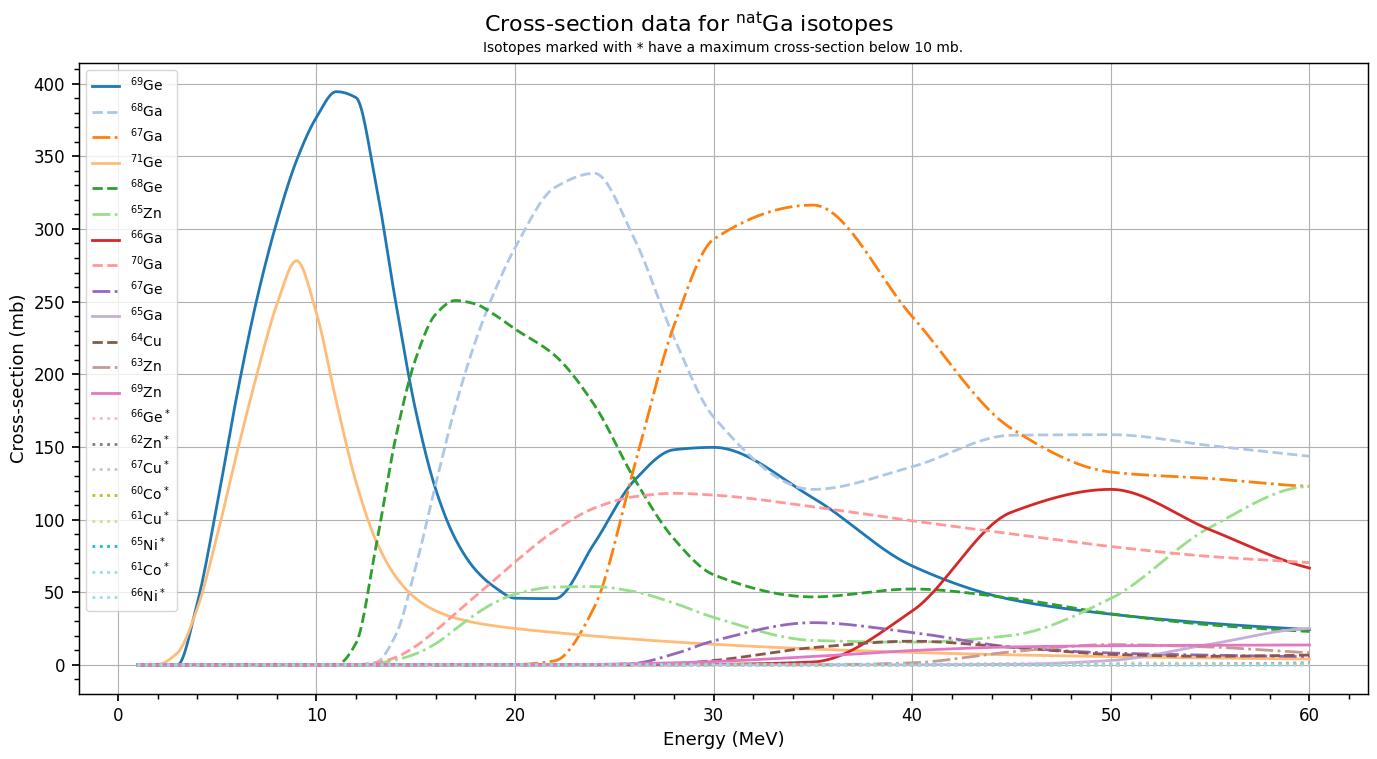

In [37]:
csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga')


sorted_filtered_isotopes_Ga = csa_Ga.filter_products_Cs(Cs_threshold=1e-2, E_limit=60, E_beam=None)
csa_Ga.plot_Cs(title=r'Cross-section data for $^{\text{nat}}$Ga isotopes', isotopes=sorted_filtered_isotopes_Ga, low_Cs_threshold=10)
plt.savefig(fig_path / 'Ga_filtered_Cs.pdf')
plt.show()

/mnt/c/Users/krist/Dokumenter/Dokumenter/PRMA/Medical-Applications-of-Nuclear-Physics/src/tendl.py:189: UserWarning: genfromtxt: Empty input file: "[]"
  tendlData = np.genfromtxt(tendlData)


Unable to retrieve tendlData from url: https://tendl.web.psi.ch/tendl_2023/proton_file/Ga/Ga069/tables/residual/rp029069.tot
Found 5/8 isotopes with cross-sections above 0.01 mb:
62Cu 66Cu 69Cu 64Ga 62Co


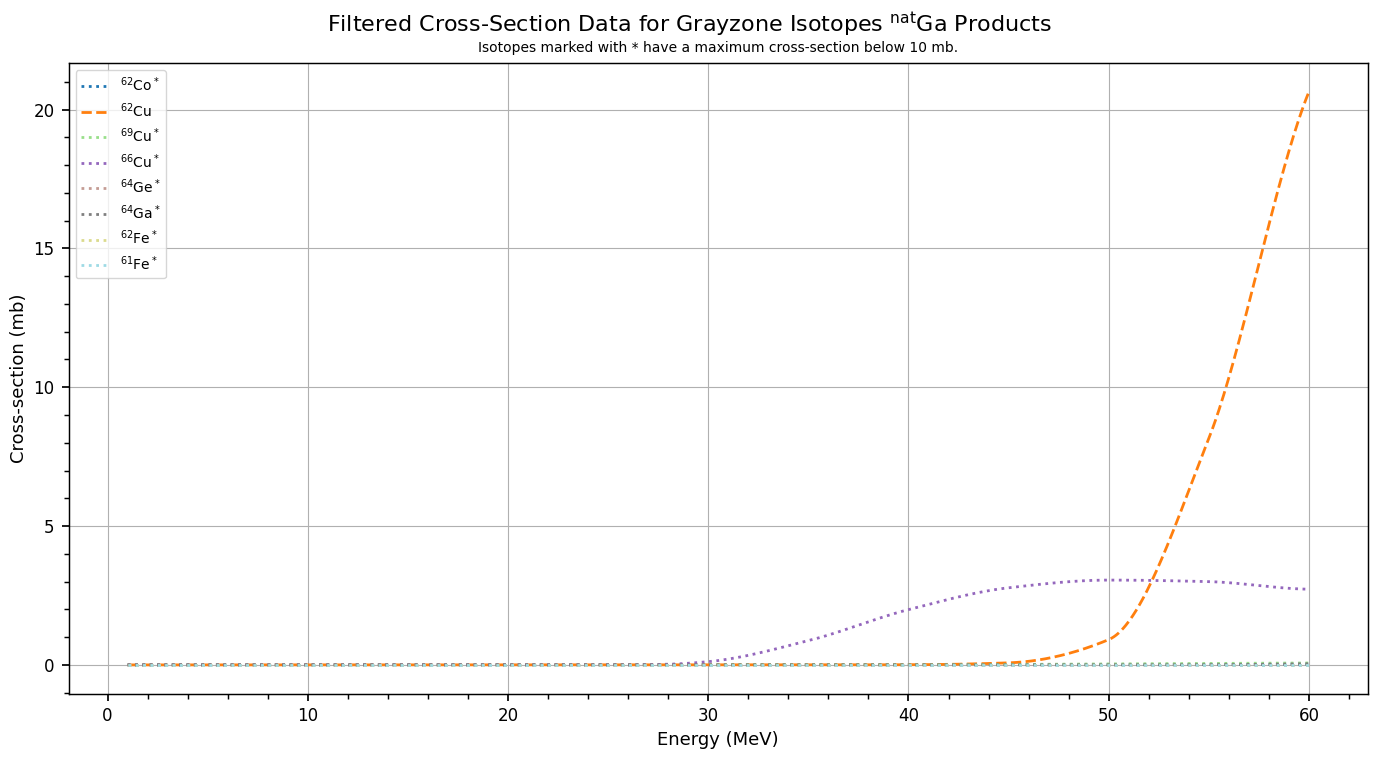

In [38]:
grayzone_products_Ga = csa_Ga.load_tendl_data(path = tendl_data_path / 'Ga', isotopes=csa_Ga.grayzone_isotopes)

sorted_filtered_grayzone_isotopes_Ga = csa_Ga.filter_products_Cs(isotopes=grayzone_products_Ga['Name'], Cs_threshold=1e-2, E_limit=60, E_beam=None)

csa_Ga.plot_Cs(title=r'Filtered Cross-Section Data for Grayzone Isotopes $^{\text{nat}}$Ga Products', isotopes=grayzone_products_Ga)
plt.savefig(fig_path / 'Ga_grayzone_filtered_Cs.pdf')
plt.show()

#### Sn (Tin)

In [39]:
# csa_Sn.save_tendl_data(path = tendl_data_path / 'Sn')

Found 31/45 isotopes with cross-sections above 0.01 mb:
119Sb 117Sb 120Sb 116Sb 115Sb 113Sn 122Sb 121Sn 124Sb 117In 123Sn 111Sn 112In 111In 110In 110Sn 109In 109Sn 109Cd 108In 107In 108Sn 107Cd 115Cd 105Cd 125Sb 106Ag 111Ag 117Cd 118Cd 105Ag


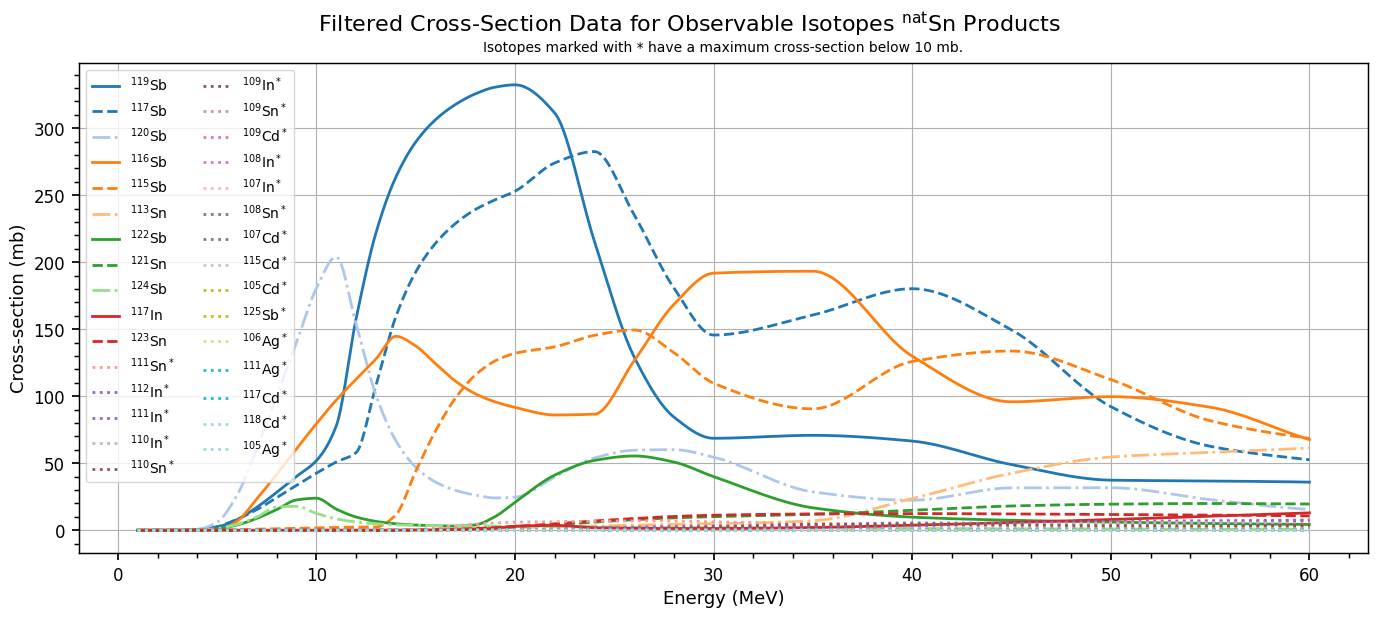

In [40]:
csa_Sn.load_tendl_data(path = tendl_data_path / 'Sn')

sorted_filtered_isotopes_Sn = csa_Sn.filter_products_Cs()
csa_Sn.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Sn Products', isotopes=sorted_filtered_isotopes_Sn)
plt.legend(loc='upper left', ncol=2)
plt.savefig(fig_path / 'Sn_filtered_Cs.pdf')
plt.show()

### Monitor Foils Cross Sections

#### Cu (Copper)

In [41]:
# csa_Cu.save_tendl_data(path = tendl_data_path / 'Cu')

Found 18/18 isotopes with cross-sections above 0.01 mb:
63Zn 65Zn 61Cu 64Cu 62Zn 57Co 58Co 60Cu 60Co 56Co 57Ni 55Fe 61Co 54Mn 59Fe 56Mn 56Ni 55Co


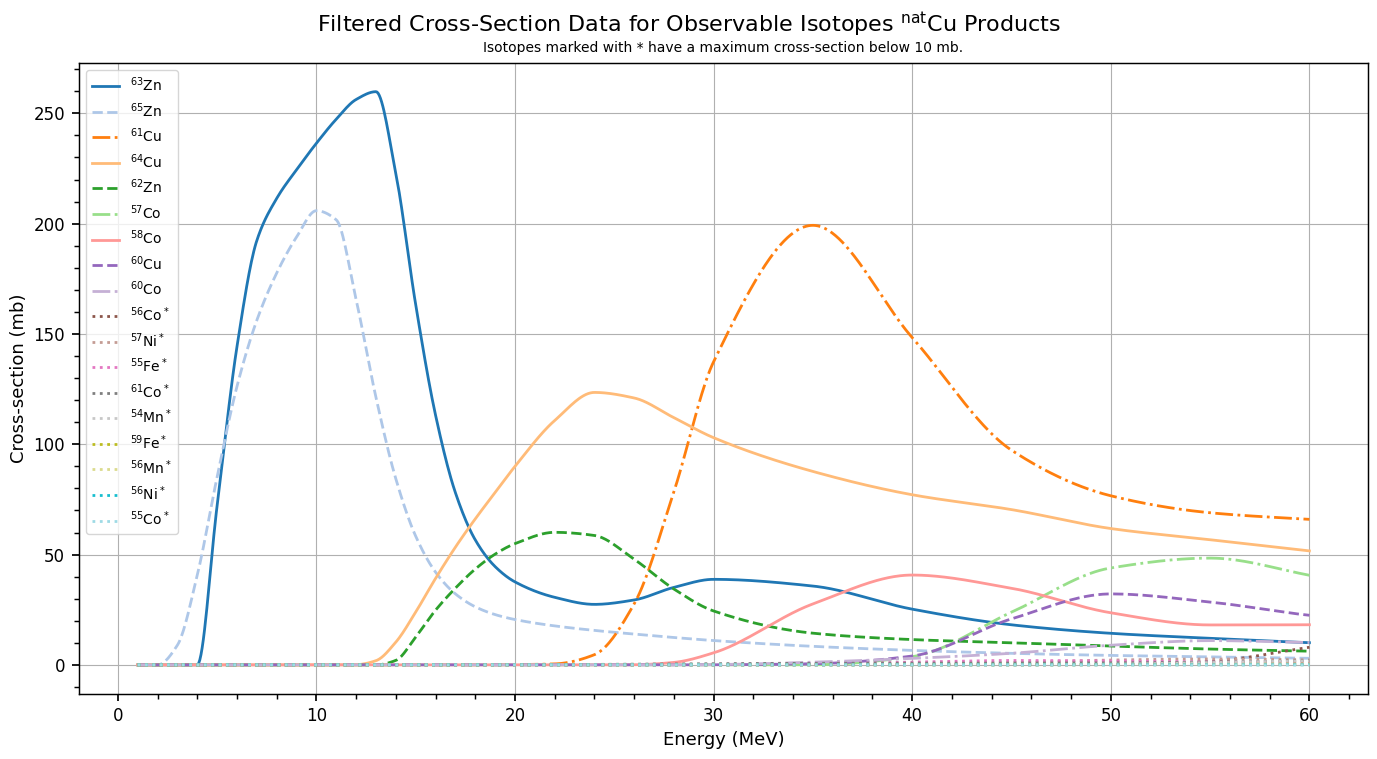

In [42]:
csa_Cu.load_tendl_data(path = tendl_data_path / 'Cu')

sorted_filtered_isotopes_Cu = csa_Cu.filter_products_Cs()
csa_Cu.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Cu Products', isotopes=sorted_filtered_isotopes_Cu)
plt.savefig(fig_path / 'Cu_filtered_Cs.pdf')
plt.show()

#### Ni (Nickel)

In [43]:
# csa_Ni.save_tendl_data(path = tendl_data_path / 'Ni')

Found 21/24 isotopes with cross-sections above 0.01 mb:
57Co 56Co 57Ni 55Fe 60Cu 58Co 55Co 52Mn 56Ni 61Cu 54Mn 64Cu 60Co 51Cr 61Co 52Fe 51Mn 49V 49Cr 59Fe 56Mn


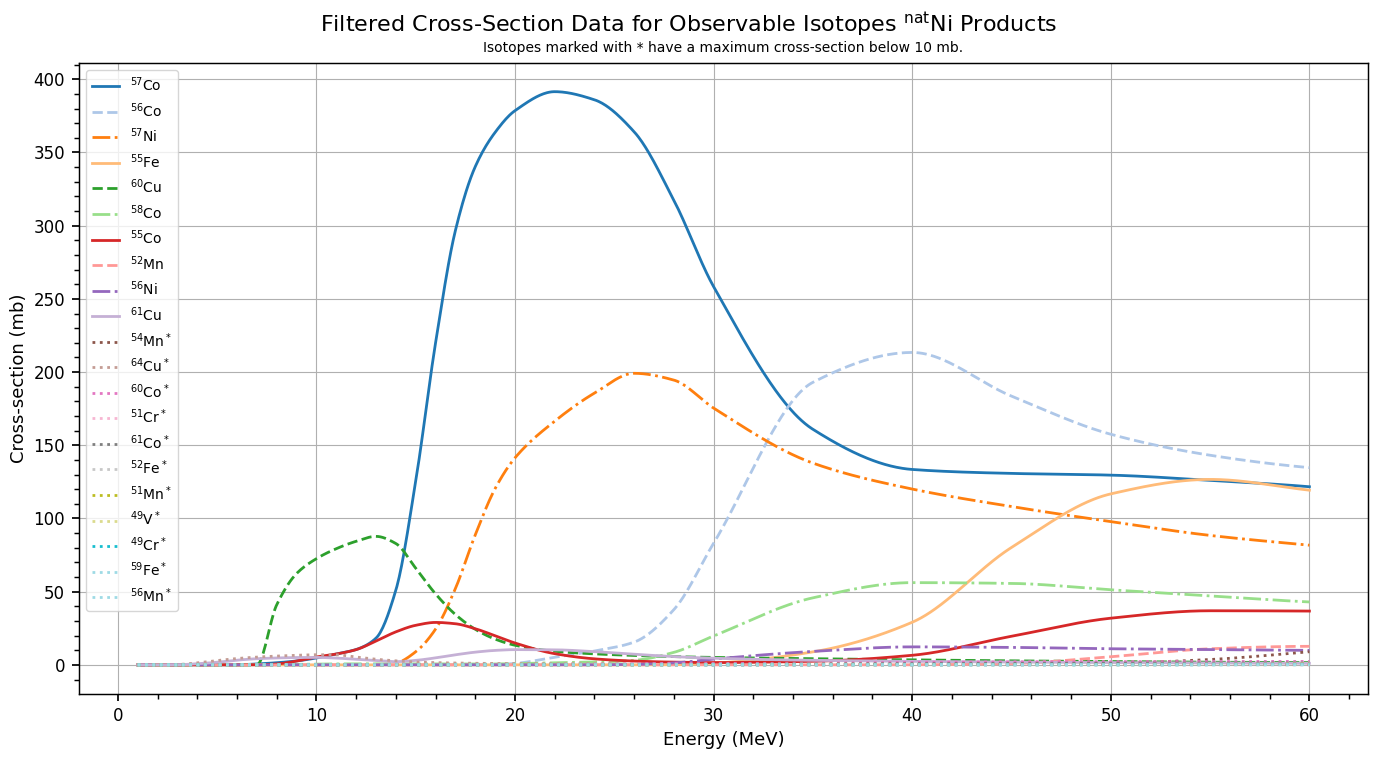

In [44]:
csa_Ni.load_tendl_data(path = tendl_data_path / 'Ni')

sorted_filtered_isotopes_Ni = csa_Ni.filter_products_Cs()
csa_Ni.plot_Cs(title=r'Filtered Cross-Section Data for Observable Isotopes $^{\text{nat}}$Ni Products', isotopes=sorted_filtered_isotopes_Ni)
plt.savefig(fig_path / 'Ni_filtered_Cs.pdf')
plt.show()

# Part 3: Calculating Counting Times

Index(['name', 'compound', 'areal_density', 'mu_E', 'sig_E'], dtype='object')


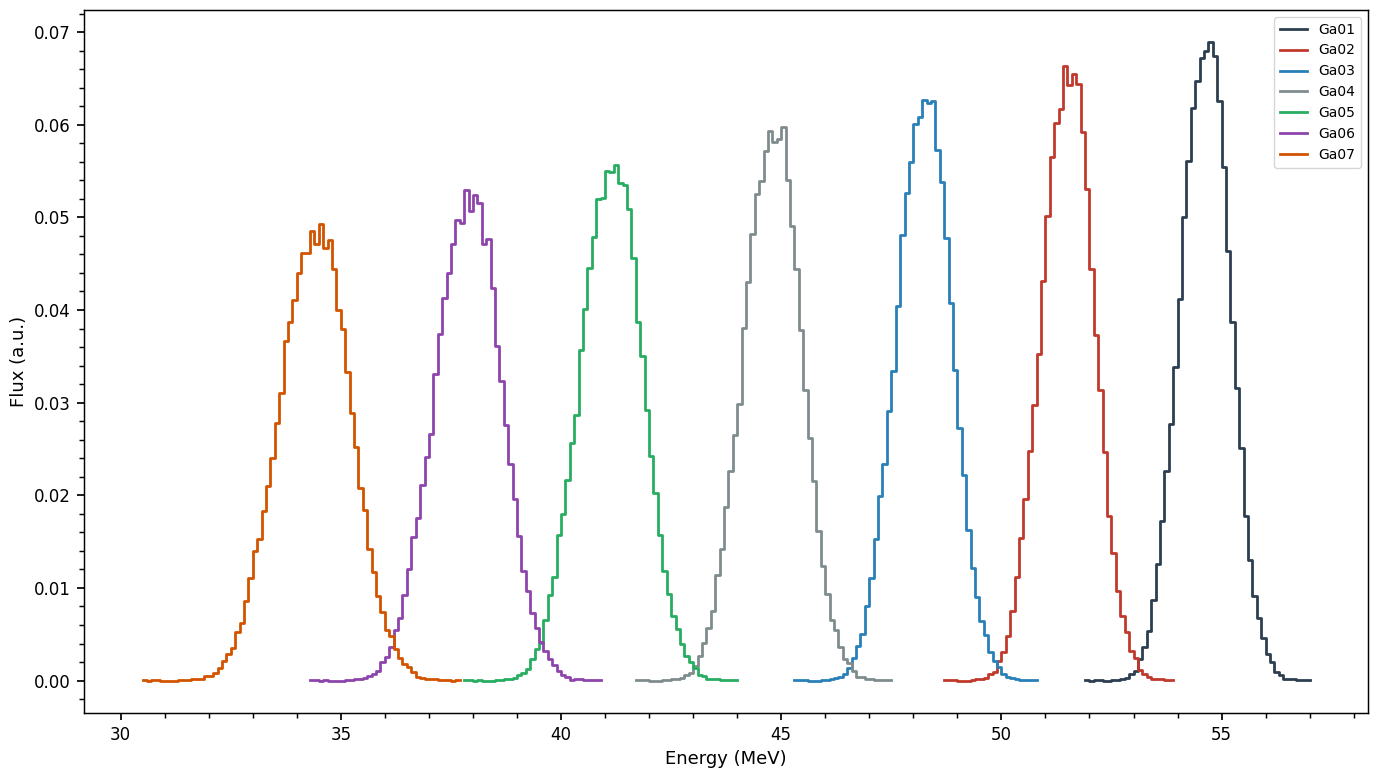

In [45]:
## Compound must be specified, and enough info to determine areal density
## Units:
## thickness: mm
## mass: g
## area: cm^2
## ad (areal density): mg/cm^2
## density: g/cm^3

x_kapton = 0.013
x_silicone = 0.013

ad_degrader_a = 599.   #2.24 mm
ad_degrader_b = 415.0   #1.55 mm
ad_degrader_c = 261.5   #0.97 mm
# ad_degrader_d = 599.0
ad_degrader_e = 68.3   #0.256 mm
ad_degrader_h = 33.8

ad_be_backing = 4.425     #23.9130435 microns

# for i in np.arange(1,11):
# 	print(i)

# 
# 55 MeV stack
# 

stack = []
for i,mult in zip(np.arange(1,8),[ad_degrader_c,ad_degrader_c,ad_degrader_c,ad_degrader_c,3*ad_degrader_e,3*ad_degrader_e,3*ad_degrader_e]):
    d = [
    {'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
            {'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
            {'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
            # {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
            {'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
            {'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
            {'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
    # print(d)
    stack = stack + d
    # stack.update(d)

# 
# 30 MeV stack
# 

# stack = []
# for i,mult in zip(np.arange(8,15),[2*ad_degrader_e,2*ad_degrader_e,2*ad_degrader_e,ad_degrader_e,ad_degrader_e,68.75,0.01]):
# 	d = [{'compound':'Ni', 'name':'Ni'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Sn', 'name':'Sn'+str(i).zfill(2), 't':0.010},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'front', 't':2*x_kapton},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'front', 't':x_silicone},
# 			{'compound':'Ga', 'name':'Ga'+str(i).zfill(2), 't':0.050},
# 			# {'compound':'Acrylic', 'name':'Acrylic_'+str(i).zfill(2)+'back', 't':x_silicone},
# 			{'compound':'Kapton', 'name':'Kapton_'+str(i).zfill(2)+'back', 't':2*x_kapton},
# 			{'compound':'Cu', 'name':'Cu'+str(i).zfill(2), 't':0.025},
# 			{'compound':'Al', 'name':'Al_degrader_E'+str(i).zfill(2), 'ad':mult}]
# 	# print(d)
# 	stack = stack+ d
# 	# stack.update(d)

# print(stack)


# # cm = ci.Compound('RbF', density=3.56)
# # print(cm.weights)


# print('Running...')
# # st = ci.Stack(stack, compounds={'RbF':{'Cu':-66, 'Zn':-33}}, E0=60.0)

st = ci.Stack(stack, E0=55.0, particle='p', dE0=0.55, N=1E4, max_steps=100)
# st = ci.Stack(stack, E0=30.0, particle='p', dE0=0.30, N=1E4, max_steps=100)
# st.saveas('lbnl_GaSn_stack_30MeV.csv')
# st.saveas('lbnl_GaSn_stack_30MeV.db')
# st.saveas('lbnl_GaSn_stack_55MeV.csv')
# st.saveas('lbnl_GaSn_stack_55MeV.db')
# # st.saveas('lbnl_w_stack.db')
# # st.saveas('lbnl_pa_stack.csv')
# st.summarize()
print(st.stack.columns)
st.plot('Ga')

In [46]:
class StackAnalysis:
    def __init__(self,
                 stack: ci.Stack, 
                 eficiency_func: Callable,  
                 proton_flux: float = 6.24e11, 
                 irradiation_time: float = 60*60):
        """
        Initializes the StackAnalysis class.
        
        Parameters
        ----------
        stack: ci.Stack
            The stack object containing the materials and their properties.
        proton_flux: float, optional
            The proton flux in protons/cm^2/s. Defaults to 6.24e11.
        irradiation_time: float, optional
            The irradiation time in seconds. Defaults to 60*60 (1 hour).
        """
        self.stack = stack
        self.efficiency_func = eficiency_func  
        self.proton_flux = proton_flux
        self.irradiation_time = irradiation_time
    
    def analyze(self, 
                products: dict[str, pd.DataFrame],
                t_d: NDArray[float64|int64] = np.arange(0, 60*60),
                t_max: float = 60*60,
                min_intensity: float = 10.0,
                dE_511: float = 0.1,
                silent: bool = True) -> pd.DataFrame:
        
        results_list = []
        for _, foil in self.stack.stack.iterrows():
            target = foil['compound']
            if target not in products:
                if not silent:
                    print(f"Element {target} not found in products: {products.keys()}. Skipping.")
                    
                continue
            
            A = foil['areal_density'] * 1E-3  # g/cm^2 
            for _, isotope in products[target].iterrows():
                iso_name = isotope['Name']
                E   = isotope['E']
                Cs  = isotope['Cs']
                iso = ci.Isotope(iso_name.upper())
                λ   = iso.decay_const()  # decays/s 
                if isinstance(λ, tuple):
                    λ = λ[0]
                    
                M   = iso.mass
                N_T = A * Avogadro / M  # atoms/cm^2
                idx = np.abs(E - foil.mu_E).argmin()  # Find the index of the closest energy to the beam energy 
                σ   = Cs[idx] * 1E-27  # Convert mb to cm^2 
                
                A0 = self._A0(σ, N_T, self.proton_flux, self.irradiation_time, λ)  # Activity in Bq 
                
                for _, gamma in iso.gammas(I_lim = min_intensity, dE_511 = dE_511).iterrows():
                    E_γ = gamma['energy']  # MeV
                    I_γ = gamma['intensity']  / 100 
                    ε_γ = self.efficiency_func(E_γ)  
                    
                    t_c = self._counting_time(A0, I_γ, t_d, ε_γ, λ)  # Counting time in seconds 
                    
                    t_c = np.atleast_1d(t_c)
                    if np.isnan(t_c).any():
                        if not silent:
                            print(f"Skipping NaN value for isotope {iso_name} from target {target} with energy {E_γ} MeV.")
                        continue
                    
                    if t_c[0] > t_max:
                        if not silent:
                            print(f"Skipping isotope {iso_name} from target {target} with counting time {t_c[0]} s, which exceeds the maximum allowed time {t_max} s.")
                        continue
                    
                    unit = iso.optimum_units()
                    entry = {'t_c0': t_c[0],
                             'gamma_energy': E_γ,
                             'isotope': iso_name,
                             'target': target,
                             'foil_number': foil['name'][-2:],
                             'half_life': f'{iso.half_life(unit):.2g} {unit}',
                             't_c': t_c,
                             't_d': t_d}
                    results_list.append(entry)
                    
        results_df = pd.DataFrame(results_list).sort_values(by='t_c0', ascending=True, ignore_index=True)
        
        return results_df
    
    def plot(self, 
             counting_times: pd.DataFrame, 
             target: str | None = None, 
             n_gammas: int = 5, 
             title: str = '') -> Figure:
        """
        Plots counting times as a function of delay times for the top gamma lines.

        Parameters
        ----------
        counting_times : pd.DataFrame
            DataFrame containing counting time data, typically the output of the `analyze` method. Needs to have columns 't_d', 't_c', 'gamma_energy', 'isotope', 'target', and 'foil_number'.
        target : str or None, optional
            If provided, only plot data for this target material. Default is None (plot all targets).
        n_gammas : int, optional
            Number of gamma lines to plot, sorted by initial counting time. Default is 5.
        title : str, optional
            Title for the plot. Default is an empty string.

        Returns
        -------
        Figure
            Matplotlib Figure object containing the plot.
        """
        if target is not None:
            counting_times = counting_times[counting_times['target'] == target]
        
        counting_times = counting_times.sort_values(by='t_c0', ascending=True, ignore_index=True)

        plot_row = lambda row: plt.plot(row['t_d'], row['t_c'], label=f"E: {row['gamma_energy']} keV, iso: {row['isotope']}, target: {row['target']}, foil: {row['foil_number']}")
                                        
        counting_times.head(n_gammas).apply(plot_row, axis=1)
        
        plt.xlabel('Delay Time (s)')
        plt.ylabel('Counting Time (s)')
        plt.title(title)
        
        plt.legend()
        plt.grid()
        plt.tight_layout()
        
        return plt.gcf() 
    
    
    def _A0(self, 
            σ:     float | NDArray[float64],  
            N_T:   int   | NDArray[int64],
            Φ:     float | NDArray[float64],
            t_irr: float | NDArray[float64], 
            λ:     float | NDArray[float64]) -> NDArray[float64]:
        """
        Calculates the activity A0 from the cross-section σ, target atom density N_T, flux Φ, irradiation time t_irr, and decay constant λ. `t_irr` and `λ` can be either a float or a numpy array. If both are arrays, they must have the same shape.
        
        Parameters
        ----------
        σ: float
            Cross-section in barns (b).
        N_T: int
            Target atom density in atoms/cm^2.
        Φ: float
            Flux in protons/cm^2/s.
        t_irr: float | int | NDArray[float64 | int64]
            Irradiation time in seconds.
        λ: float | NDArray[float]
            Decay constant in decays/s.
            
        Returns
        -------
        float | NDArray[float64]
            Activity A0 in Bq.
        """
        if isinstance(t_irr, np.ndarray) and isinstance(λ, np.ndarray):
            assert t_irr.shape == λ.shape, "If both t_irr and λ are numpy arrays, they must have the same shape."
        
        A0 = σ * N_T * Φ * (1 - np.exp(-λ * t_irr))
        
        return A0
    
    def _counting_time(self, 
                       A0:  float | NDArray[float64], 
                       I_γ: float | NDArray[float64], 
                       t_d: float | NDArray[float64|int64], 
                       ε_γ: float | NDArray[float64], 
                       λ:   float | NDArray[float64], 
                       N_c: int   | NDArray[int64] = 10_000) -> float | NDArray[float64]:
        """
        Calculates the counting time t_c to count N_c decays, as a function of delay time t_d. All arrays passed for `A0`, `I_γ`, `t_d`, `ε_γ`, `λ` or `N_c` must all have the same shape. 
        
        Parameters
        ----------
        A0: float | int | NDArray[float | int64]
            Initial activity in Bq.
        I_γ: float | int | NDArray[float | int64]
            Intensity of the gamma line.
        t_d: np | NDArray[np]
            Delay time in seconds.
        ε_γ: float | int | NDArray[float | int64]
            Energy of the gamma line in MeV.
        λ: float | int | NDArray[float | int64]
            Decay constant in decays/s.
        N_c: int | NDArray[int], optional
            Number of counts to achieve. Defaults to 10'000.
            
        Returns
        -------
        float | int | NDArray[float | int64]
            Counting time in seconds.
        """
        t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
        return t_c

In [48]:
Φ = 6.24e11  # Proton flux in protons/cm^2/s
t_irr = 60 * 60  # Irradiation time in seconds (1

sa = StackAnalysis(st, eficiency_func=cb.eff, proton_flux=Φ, irradiation_time=t_irr)

In [54]:
products = {
    'Ga': sorted_filtered_isotopes_Ga,
    'Sn': sorted_filtered_isotopes_Sn,
    'Cu': sorted_filtered_isotopes_Cu,
    'Ni': sorted_filtered_isotopes_Ni
}

results = sa.analyze(products=products, t_d=np.arange(0, 60*60*24*3), t_max=60*60, min_intensity=10.0, dE_511=0.1, silent=True)
print(results.head())

/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: invalid value encountered in log
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ
/tmp/ipykernel_60632/3453129009.py:199: Runtim

       t_c0  gamma_energy isotope target foil_number half_life  \
0  1.370274       1039.22    66Ga     Ga          03     9.5 h   
1  1.392407       1039.22    66Ga     Ga          02     9.5 h   
2  1.558877       1039.22    66Ga     Ga          04     9.5 h   
3  1.704703       1039.22    66Ga     Ga          01     9.5 h   
4  1.854069         93.31    67Ga     Ga          07     3.3 d   

                                                 t_c  \
0  [1.370274391509861, 1.370302193427161, 1.37032...   
1  [1.3924070903255914, 1.3924353413025539, 1.392...   
2  [1.5588772866882408, 1.5589089152871158, 1.558...   
3  [1.7047033318687852, 1.7047379192328127, 1.704...   
4  [1.8540686160348188, 1.854073176350312, 1.8540...   

                                                 t_d  
0  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
1  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
3  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 

/tmp/ipykernel_60632/3453129009.py:199: RuntimeWarning: divide by zero encountered in divide
  t_c =  np.log(1 - (N_c*λ)/(A0 * I_γ * ε_γ * np.exp(-λ * t_d))) / -λ


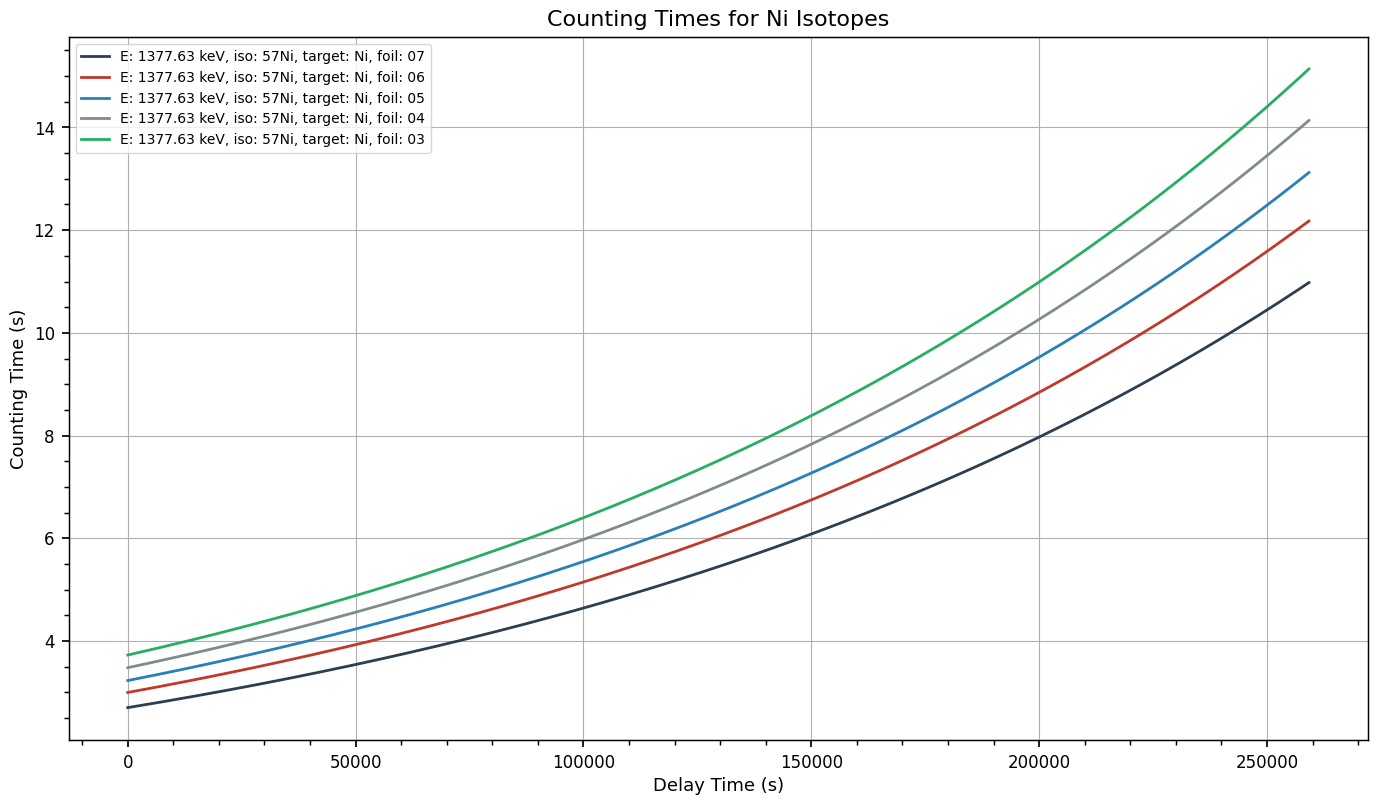

In [ ]:
sa.plot(results, target='Ni')
plt.show()